<a href="https://colab.research.google.com/github/lapidesd/ET_layers/blob/main/Code/phydrus_VMS_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up and run HYDRUS

In [40]:
# install HYDRUS
!pip install -q phydrus

In [41]:
# grab HYDRUS source code
!git clone https://github.com/phydrus/source_code
!git clone https://github.com/phydrus/phydrus

fatal: destination path 'source_code' already exists and is not an empty directory.
fatal: destination path 'phydrus' already exists and is not an empty directory.


In [42]:
%%bash
cd /content/source_code
cp ./source/* .
make
cp -r /content/phydrus/examples/phydrus_paper/* /content

make: 'hydrus' is up to date.


In [43]:
# import packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import phydrus as ps

In [44]:
# set up HYDRUS to run

exe = '/content/source_code/hydrus'
# Folder for Hydrus files to be stored
#Folder where the Hydrus files are to be stored
ws = "/content/output"

# Create model
ml = ps.Model(exe_name=exe, ws_name=ws, name="model",
              mass_units="mmol", time_unit="days", length_unit="cm")

atm = pd.read_csv("./data/atmosphere.csv", index_col=0)

ml.add_time_info(tinit=0, tmax=len(atm)+1,print_times=True)
ml.add_waterflow(top_bc=3, bot_bc=4)

# Add the process solute transport
ml.add_solute_transport(lupw=True)

# Add materials - soil params from Jesse - best fit Rivendell?
m = ml.get_empty_material_df(n=1)
m.loc[0:1] = [[0.218, 0.520, 0.015, 2.03, 31.6, 0.5, 1.5, 30.0, 1, 0]]
ml.add_material(m)

# Define loop for potential root water uptake distribution proposed by Hoffman and Van Genuchten
def z_loop(z, r1=10, r2=20):
    if z > -r1:
        return 1
    elif z < -(r1 + r2):
        return 0
    else:
        return(z + (r1 + r2)) / r2

# bottom of each layer
bottom = [-800]  # Depth of the soil column
nodes = 800  # Dictretize into n nodes
ihead = -100  # Determine initial pressure head
ps.create_profile()

# mat/lay options assign materials to layers?
profile = ps.create_profile(bot=bottom, dx=abs(bottom[-1] / nodes), h=ihead, conc=1e-10)
# root profile
profile["Beta"] = profile.apply(lambda row: z_loop(row["x"],100,600), axis=1)
ml.add_profile(profile)

ml.add_root_uptake(model=0, crootmax=1e10, omegac=0, p2h=-1500, p2l=-1500, poptm=[-100])

obs_depths = list(range(-10,-200,-10))
ml.add_obs_nodes(obs_depths)

sol = ml.get_empty_solute_df()
sol.loc[:, "beta"] = 1.0
ml.add_solute(sol,difw=1e-9)

elder = pd.read_csv('https://hydroeco.github.io/angelo/angelo_weather_1H.csv', parse_dates=True, index_col=0)
elder = pd.read_csv('https://raw.githubusercontent.com/daviddralle/daviddralle.github.io/master/ppt.csv',index_col=0,parse_dates=True)
elder = elder.resample('D').first().fillna(0)
# change units to cm from mm
elder = elder[['11475560']]*.1
# set time period for simulation
elder = elder.loc['2011-01-01':]
elder = elder.iloc[:len(atm):]

elder['idx'] = range(len(elder))
idx = elder['idx'].values
dates = elder.index.values

atm['Prec'] = elder.values
ml.add_atmospheric_bc(atm, hcrits=0)

ml.profile['Conc'] = 0
half = int(len(ml.profile)/10)
ml.profile['Conc'].iloc[:half] = 1

ml.write_atmosphere()


<ipython-input-44-438b99ab1c55>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ml.profile['Conc'].iloc[:half] = 1
INFO: Successfully wrote /content/output/ATMOSPH.IN
INFO:phydrus.model:Successfully wrote /content/output/ATMOSPH.IN


In [45]:
# Write the input and check if the model simulates
ml.write_input()
ml.simulate()

INFO: Successfully wrote /content/output/SELECTOR.IN
INFO:phydrus.model:Successfully wrote /content/output/SELECTOR.IN
INFO: Successfully wrote /content/output/PROFILE.DAT
INFO:phydrus.model:Successfully wrote /content/output/PROFILE.DAT
INFO: Successfully wrote /content/output/ATMOSPH.IN
INFO:phydrus.model:Successfully wrote /content/output/ATMOSPH.IN
INFO: Hydrus-1D Simulation Successful.
INFO:phydrus.model:Hydrus-1D Simulation Successful.


CompletedProcess(args=['/content/source_code/hydrus', '/content/output', '-1'], returncode=0)

In [46]:
# read HYDRUS outputs into dataframe

d = ml.read_nod_inf(times=list(range(1,697)))
for key in d.keys():
  d[key]['time'] = key
appendfiles = [d[key] for key in d.keys()]
alldata = pd.concat(appendfiles)

("Head",          "Moisture",       "K",                      "C",                 "Flux",      "Sink",         "Temp")

("Pressure Head", "Water Content", "Hydraulic Conductivity", "Hydraulic Capacity","Water Flux", "Root Uptake", "Temperature")

["h [{}]".format(l_unit), "Theta [-]", f"K [{l_unit}/days]",
                 f"C [1/{l_unit}]", f"v [{l_unit}/{t_unit}]",
                 f"S [1/{t_unit}]", "T [°C]"]

# Set up functions for running mass balance formulas against HYDRUS

In [47]:
def prep_data(nodespacing,timeres=1):
  # prepare data for running a mass balance method
  # for a certain temporal and vertical resolution

  alldata['Nodegroup'] = np.where(alldata.Depth>=-1*nodespacing,1,-1)
  nodedepths = list(range(nodespacing,801,nodespacing))
  for i,thresh in enumerate(nodedepths):
    alldata['Nodegroup'] = np.where((-alldata.Depth<=thresh) & (alldata.Nodegroup<0),
                                  i+1,alldata.Nodegroup)

  pet = ml.read_tlevel()[['rRoot','rTop']]
  pet['rTop'] = np.where(pet.rTop<0,0,pet.rTop)
  pet = pet.sum(axis=1).rename('PET').to_frame()


  et = ml.read_tlevel()[["vRoot"]]
  et = et.sum(axis=1).rename('vRoot')

  ETdata = alldata[['Nodegroup','time','Sink']].groupby(['Nodegroup',
                                                        'time']).sum().reset_index().set_index('time')
  ETdata = ETdata.merge(et,left_index=True,right_index=True)
  ETdata['ET'] = ETdata.Sink#*ETdata.vRoot
  ETdata.drop(columns=['Sink','vRoot'],inplace=True)

  wcdata = alldata[['Nodegroup','time','Moisture']].groupby(['Nodegroup','time']).mean().reset_index().set_index('time')

  fluxdata = alldata[alldata.Node.isin(list(range(10,801,10)))][['Nodegroup','time','Flux']].groupby(
      ['time','Nodegroup',]).last().reset_index().set_index('time')

  rain = ml.atmosphere['Prec'].reset_index()
  combodata = wcdata.reset_index().merge(fluxdata.reset_index(),on=['time','Nodegroup'])
  combodata = combodata.merge(ETdata.reset_index().rename(columns={'ET':'ETnode',
                                                                  'index':'time'}),
                              on=['time','Nodegroup'])
  combodata['deltaS'] = (combodata.Moisture*10).diff().fillna(0)
  combodata = combodata.merge(rain.rename(columns={'index':'time'}),
                              on='time')

  return(combodata,rain,pet,et,nodedepths)

In [48]:
# Storages = []
# for node in combodata.Nodegroup.unique():
#   if node==1:
#     nodefactor = nodespacing
#   else:
#     nodefactor = nodespacing
#   Storages.append((combodata[combodata.Nodegroup==node][['time',
#                                                         'Moisture']].set_index(
#                                                             'time')*nodefactor).rename(columns={
#                                                                 'Moisture':node}))
# Storages = pd.concat(Storages,axis=1)
# Storages

In [49]:
def calc_fluxes_mymethod(num_ports,nodespacing,timeres=1):
  # run Method 3 (minimum drainage) on HYDRUS fluxes to get
  # depth-distributed ET and drainage fluxes

  Storages = []
  for node in combodata.Nodegroup.unique():
    if node==1:
      nodefactor = nodespacing
    else:
      nodefactor = nodespacing
    Storages.append((combodata[combodata.Nodegroup==node][['time',
                                                          'Moisture']].set_index(
                                                              'time')*nodefactor).rename(columns={
                                                                  'Moisture':node}))
  Storages = pd.concat(Storages,axis=1)
  Storages = Storages.iloc[::timeres]

  # calculate deltaS for each timestep
  DeltaStorage = Storages.diff().dropna()
  P = rain.rename(columns={'Prec':'J [mm/h]'})[['J [mm/h]']].shift(1)
  DeltaStorage = DeltaStorage.merge(P.rolling(timeres,center=False).sum(),
                                    left_index=True,right_index=True)
  ports = list(range(1,num_ports+1))

  # data checks
  # 1. confirm that the change over no single layer exceeds incoming P

  # remove first step because it fails P test and no prior P to correct with
  DeltaStorage = DeltaStorage#.iloc[2:]

  # make a column of minimum J needed to meet requirement
  collist = []
  for col in ports+[ports[-1]+1]:
      collist.append(col)
      DeltaStorage['minJ_'+str(col)] = DeltaStorage[collist].sum(axis=1)

  DeltaStorage['minJ'] = DeltaStorage[['minJ_'+str(i) for i in ports+[ports[-1]+1]]].max(axis=1)
  DeltaStorage.drop(columns=['minJ_'+str(i) for i in ports+[ports[-1]+1]],inplace=True)

  # find timesteps where requirement is not met.
  DeltaStorage['Jdiff'] = DeltaStorage['J [mm/h]']-DeltaStorage.minJ
  DeltaStorage['Jadjust'] = DeltaStorage['J [mm/h]'].values
  DeltaStorage['Jdiff_new'] = DeltaStorage.Jdiff.values


  Jdiffnew = list(DeltaStorage.Jdiff)
  for i in range(len(DeltaStorage)):
      if DeltaStorage.Jdiff.values[i]<0:
          # if excess P available in previous timestep, shift it
          adjustby = 0
          if DeltaStorage.Jdiff_new.values[i-1]>=abs(DeltaStorage.Jdiff_new.values[i]):
              adjustby = abs(DeltaStorage.Jdiff.values[i])
              Jdiffnew[i] = 0
              Jdiffnew[i-1] -= adjustby
              DeltaStorage['Jdiff_new'] = Jdiffnew
          else:
              adjustby = abs(DeltaStorage.Jdiff_new.values[i-1])
              Jdiffnew[i]+=adjustby
              Jdiffnew[i-1] = 0
              DeltaStorage['Jdiff_new'] = Jdiffnew
          if i>0:
              DeltaStorage['Jadjust'] = list(DeltaStorage.Jadjust.values[:i-1])+ [
                                              DeltaStorage.Jadjust.values[i-1]-adjustby,
                                              DeltaStorage.Jadjust.values[i]+adjustby] + list(
                                              DeltaStorage.Jadjust.values[i+1:])
          else:
              DeltaStorage['Jadjust'] = [DeltaStorage.Jadjust.values[i]+adjustby] + list(
                                              DeltaStorage.Jadjust.values[i+1:])
          # if there is still an issue, and the values is less than 1, then just add what's needed back in
          # and ignore it...correct it. This error is small now
          if (abs(DeltaStorage.Jdiff_new.values[i])>0):
              adjustfinal = abs(DeltaStorage.Jdiff.values[i])-adjustby
              Jdiffnew[i] = 0
              DeltaStorage['Jdiff_new'] = Jdiffnew
              DeltaStorage['Jadjust'] = list(DeltaStorage.Jadjust.values[:i])+ [
                                              DeltaStorage.Jadjust.values[i]+
                                              adjustfinal] + list(DeltaStorage.Jadjust.values[i+1:])


  fractional_Pchange = (DeltaStorage.Jdiff_new-DeltaStorage.Jdiff).sum()/DeltaStorage['J [mm/h]'].sum()
  print('To meet mass balance, increased overall P by ',round(fractional_Pchange*100),'%')

  DeltaStorage_use = DeltaStorage[['Jadjust']+[i for i in range(1,len(combodata.Nodegroup.unique()))]]

  # Now, do something similar to constrain drainage terms.
  # For each drainage term, minimum drainage must meet
  # requirements of set of storage increases from below
  DeltaStorage = DeltaStorage_use

  # make a column of minimum d0 needed to meet requirement from below
  # this is drainage from soil to A1

  for dnum in range(1,len(ports)+2):
      collist = []
      for col in [i for i in range(dnum+1,len(ports)+2)]:
          collist.append(col)
          DeltaStorage['mind'+str(dnum)+'_'+str(col)] = DeltaStorage[collist].sum(axis=1)

      DeltaStorage['mind'+str(dnum)] = DeltaStorage[['mind'+str(dnum)+'_'+str(i)
                                                        for i in range(dnum+1,len(ports)+2)]].max(axis=1)

      DeltaStorage['mind'+str(dnum)] = np.where(DeltaStorage['mind'+str(dnum)]<0,0,
                                                    DeltaStorage['mind'+str(dnum)])



  # add in storage state for each layer
  for col in Storages.columns:
      DeltaStorage['S'+str(col)] = Storages[col]#[2:]

  # add in PET data
  DeltaStorage = DeltaStorage.merge(pet.rolling(timeres,center=False).sum(),left_index=True,right_index=True)



  import copy
  DeltaStorage_spinup = copy.deepcopy(DeltaStorage)
  DeltaStorage_spinup['time'] = DeltaStorage_spinup.index-len(DeltaStorage_spinup)
  DeltaStorage_spinup.set_index('time',inplace=True)
  DeltaStorage = pd.concat([DeltaStorage_spinup,DeltaStorage])

  # num_ports = 4#len(ports)

  for col in ports:
      DeltaStorage['abs'+str(col)] = np.where(DeltaStorage[col]<0,0,DeltaStorage[col])



  for port in ports:
      if port==1:
        drainage_in = 'Jadjust'
      else:
        drainage_in = 'd'+str(port-1)
      drainage = 'd'+str(port)
      etterm = 'ET'+str(port)

      # if negative storage change over whole column is smaller than PET magnitude,
      # all negative storage change goes to ET, so drainage is minimum needed to meet mass balance

      DeltaStorage[drainage] = np.where(
          # True,
                                        DeltaStorage['Jadjust'] -
                                        DeltaStorage[[i for i in range(1,num_ports+1)]].sum(axis=1)<=
                                      DeltaStorage['PET'].rolling(7).max(),
                                        DeltaStorage['min'+drainage],
                                                    np.nan
                                        )
      DeltaStorage[etterm] = DeltaStorage[drainage_in] - DeltaStorage[drainage] - DeltaStorage[port]
      DeltaStorage[etterm] = np.where(DeltaStorage[drainage].isna(),np.nan,DeltaStorage[etterm])
      DeltaStorage[etterm] = np.where(DeltaStorage[etterm]<0,np.nan,DeltaStorage[etterm])



      # otherwise, set ET to maximum value over previous week

      DeltaStorage[etterm] = np.where(DeltaStorage[drainage].isna(),
                                    DeltaStorage[etterm].rolling(7).quantile(.5).interpolate().bfill(),
                                    DeltaStorage[etterm])


      DeltaStorage[drainage] = np.where(DeltaStorage[drainage].isna(),
                                      DeltaStorage[drainage_in] -
                                      DeltaStorage[etterm] -
                                      DeltaStorage[port],
                                      DeltaStorage[drainage])

  DeltaStorage['ET_total'] = DeltaStorage[['ET'+str(i+1) for i in range(num_ports)]].sum(axis=1)
  DeltaStorage = DeltaStorage.iloc[len(DeltaStorage_spinup):]



  return DeltaStorage

In [50]:
def calc_fluxes_massbal_only(num_ports,nodespacing):
  # run Method 1 (dry periods only) on HYDRUS fluxes to get
  # depth-distributed ET and drainage

  Storages = []
  for node in combodata.Nodegroup.unique():
    if node==1:
      nodefactor = nodespacing
    else:
      nodefactor = nodespacing
    Storages.append((combodata[combodata.Nodegroup==node][['time',
                                                          'Moisture']].set_index(
                                                              'time')*nodefactor).rename(columns={
                                                                  'Moisture':node}))
  Storages = pd.concat(Storages,axis=1)

  # calculate deltaS for each timestep
  DeltaStorage = Storages.diff().dropna()
  P = rain.rename(columns={'Prec':'J [mm/h]'})[['J [mm/h]']].shift(1)
  DeltaStorage = DeltaStorage.merge(P,left_index=True,right_index=True)
  ports = list(range(1,num_ports+1))


  DeltaStorage['Jadjust'] = DeltaStorage['J [mm/h]']
  # add in PET data
  DeltaStorage = DeltaStorage.merge(pet,left_index=True,right_index=True)


  DeltaStorage_use = DeltaStorage[['Jadjust']+[i for i in range(1,len(combodata.Nodegroup.unique()))]]

  # add in storage state for each layer
  for col in Storages.columns:
      DeltaStorage['S'+str(col)] = Storages[col]#[2:]

  # add spinup
  import copy
  DeltaStorage_spinup = copy.deepcopy(DeltaStorage)
  DeltaStorage_spinup['time'] = DeltaStorage_spinup.index-len(DeltaStorage_spinup)
  DeltaStorage_spinup.set_index('time',inplace=True)
  DeltaStorage = pd.concat([DeltaStorage_spinup,DeltaStorage])

  for col in ports:
      DeltaStorage['abs'+str(col)] = np.where(DeltaStorage[col]<0,0,DeltaStorage[col])


  for port in ports:
      if port==1:
        drainage_in = 'Jadjust'
      else:
        drainage_in = 'd'+str(port-1)
      drainage = 'd'+str(port)
      etterm = 'ET'+str(port)

      # if no precipitation happens today or yesterday,
      # then assume no drainage and calculate ET

      DeltaStorage[drainage] = np.where((DeltaStorage['Jadjust']==0) & (DeltaStorage.Jadjust.shift(1)==0),
                                        0,
                                                    np.nan
                                        )
      DeltaStorage[etterm] = DeltaStorage[drainage_in] - DeltaStorage[drainage] - DeltaStorage[port]
      DeltaStorage[etterm] = np.where(DeltaStorage[drainage].isna(),np.nan,DeltaStorage[etterm])


  DeltaStorage['ET_total'] = DeltaStorage[['ET'+str(i) for i in ports]].sum(axis=1)
  DeltaStorage['ET_total'] = np.where(DeltaStorage[drainage].isna(),np.nan,DeltaStorage.ET_total)
  DeltaStorage = DeltaStorage.iloc[len(DeltaStorage_spinup):]



  return DeltaStorage

In [51]:
def calc_fluxes_massbal_powerlaw(num_ports,nodespacing,ksat = 1.25):
  # run Method 2 (power law drainage) on HYDRUS fluxes to get
  # depth-distributed ET and drainage

  Storages = []
  for node in combodata.Nodegroup.unique():
    if node==1:
      nodefactor = nodespacing
    else:
      nodefactor = nodespacing
    Storages.append((combodata[combodata.Nodegroup==node][['time',
                                                          'Moisture']].set_index(
                                                              'time')*nodefactor).rename(columns={
                                                                  'Moisture':node}))
  Storages = pd.concat(Storages,axis=1)
  import copy
  RelStorages = copy.deepcopy(Storages)
  for col in RelStorages.columns:
    RelStorages[str(col)+'_rel'] = (Storages[col]-Storages[col].min())/(Storages[col].max()-Storages[col].min())
  RelStorages.drop(columns=Storages.columns,inplace=True)


  # calculate deltaS for each timestep
  DeltaStorage = Storages.diff().dropna()
  DeltaStorage = DeltaStorage.merge(RelStorages,left_index=True,right_index=True)
  P = rain.rename(columns={'Prec':'J [mm/h]'})[['J [mm/h]']].shift(1)
  DeltaStorage = DeltaStorage.merge(P,left_index=True,right_index=True)
  ports = list(range(1,num_ports+1))
  # print(ports)

  DeltaStorage['Jadjust'] = DeltaStorage['J [mm/h]']
  # add in PET data
  DeltaStorage = DeltaStorage.merge(pet,left_index=True,right_index=True)


  DeltaStorage_use = DeltaStorage[['Jadjust']+[i for i in range(1,len(combodata.Nodegroup.unique()))]]

  # add in storage state for each layer
  for col in Storages.columns:
      DeltaStorage['S'+str(col)] = Storages[col]#[2:]

  # add spinup
  import copy
  DeltaStorage_spinup = copy.deepcopy(DeltaStorage)
  DeltaStorage_spinup['time'] = DeltaStorage_spinup.index-len(DeltaStorage_spinup)
  DeltaStorage_spinup.set_index('time',inplace=True)
  DeltaStorage = pd.concat([DeltaStorage_spinup,DeltaStorage])

  for col in ports:
      DeltaStorage['abs'+str(col)] = np.where(DeltaStorage[col]<0,0,DeltaStorage[col])

  # calibrate power for drainage
  port = 1
  kgevals = []
  powers = np.linspace(1,10,100)
  relstorage = DeltaStorage['S'+str(port)]
  relstorage = ((relstorage-relstorage.min())/(relstorage.max()-relstorage.min())).iloc[-695:]

  for power in powers:

    for port in ports:
        if port==1:
          drainage_in = 'Jadjust'
        else:
          drainage_in = 'd'+str(port-1)
        drainage = 'd'+str(port)
        etterm = 'ET'+str(port)

        # if no precipitation happens today or yesterday,
        # then assume no drainage and calculate ET

        relstorage = DeltaStorage['S'+str(port)]
        relstorage = (relstorage-relstorage.min())/(relstorage.max()-relstorage.min())
        DeltaStorage[drainage] = ksat*relstorage**power
        DeltaStorage[etterm] = DeltaStorage[drainage_in] - DeltaStorage[drainage] - DeltaStorage[port]


    DeltaStorage['ET_total'] = DeltaStorage[['ET'+str(i) for i in ports]].sum(axis=1)
    kgevals.append(kge(DeltaStorage.ET_total.values.flatten()[len(DeltaStorage_spinup):],
                       combodata.groupby('time').sum().ETnode.values.flatten()[1:]))
  bestpower = np.argmax(kgevals)
  bestpower = powers[bestpower]

  for port in ports:
      if port==1:
        drainage_in = 'Jadjust'
      else:
        drainage_in = 'd'+str(port-1)
      drainage = 'd'+str(port)
      etterm = 'ET'+str(port)

      # if no precipitation happens today or yesterday,
      # then assume no drainage and calculate ET

      relstorage = DeltaStorage['S'+str(port)]
      relstorage = (relstorage-relstorage.min())/(relstorage.max()-relstorage.min())
      DeltaStorage[drainage] = ksat*relstorage**bestpower
      DeltaStorage[etterm] = DeltaStorage[drainage_in] - DeltaStorage[drainage] - DeltaStorage[port]


  DeltaStorage['ET_total'] = DeltaStorage[['ET'+str(i) for i in ports]].sum(axis=1)

  DeltaStorage = DeltaStorage.iloc[len(DeltaStorage_spinup):]



  return DeltaStorage

In [52]:
# define KGE for model evaluation

from scipy.stats import pearsonr
def kge(modeled, observed):
    newdf = pd.DataFrame.from_dict({'modeled':modeled, 'observed':observed})
    newdf = newdf.dropna()
    CC = pearsonr(newdf.modeled, newdf.observed)[0]
    cm = np.nanmean(modeled)
    rm = np.nanmean(observed)
    cd = np.nanstd(modeled)
    rd = np.nanstd(observed)
    r = CC
    alpha = cd/rd
    beta = cm/rm
    kge_val = 1-((r-1)**2+(alpha-1)**2+(beta-1)**2)**0.5
    return(kge_val)

In [53]:
def run_times(nodedepths,fluxmethod,timeres):
  # define a method to evaluate the impact of temporal resolution on method performance

  ET_totals = []
  numports = []
  mediangap = []
  maxgap = []
  num_over14 = []
  ETdiffs = []
  kges = []
  massbal_error = []


  DeltaStorages = {}

  for num_ports in [20]:
    print(num_ports)

    DeltaStorage = fluxmethod(num_ports,nodespacing,timeres)


    ET_totals.append(DeltaStorage.ET_total.sum())
    ETdiffs.append(np.nansum(abs(DeltaStorage.ET_total-et[-len(DeltaStorage)*timeres::timeres]
                                                        )/(len(DeltaStorage)*timeres)))
    ETerr = DeltaStorage[['ET'+str(i) for i in range(1,num_ports)]]
    for col in ETerr.columns:
      ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)
    massbal_error.append(ETerr.sum(axis=1).sum())
    kges.append(kge(DeltaStorage.ET_total.values.flatten(),
                    et.iloc[-len(DeltaStorage):]
                    .values.flatten()))
    numports.append(num_ports)

    DeltaStorages[num_ports] = DeltaStorage



  portsdf = pd.DataFrame.from_dict({'num_ports':numports,
                                    'ET_total':ET_totals,
                                    'ET_totalMAE':ETdiffs,
                                    'ET_totalKGE':kges,
                                    'missingData':1-len(DeltaStorage.dropna())/len(DeltaStorage),
                                    'massbal_error':massbal_error,
                                    })

  return DeltaStorages,portsdf

In [54]:
def run_nodenums(nodedepths,fluxmethod,timeres=1):
  # method to evaluate effect of vertical resolution and maximum depth
  # on method performance

  ET_totals = []
  numports = []
  mediangap = []
  maxgap = []
  num_over14 = []
  ETdiffs = []
  kges = []
  massbal_error = []


  DeltaStorages = {}

  for num_ports in range(1,len(nodedepths)-1):
    print(num_ports)

    DeltaStorage = fluxmethod(num_ports,nodespacing)


    ET_totals.append(DeltaStorage.ET_total.sum())
    ETdiffs.append(np.nansum(abs(DeltaStorage.ET_total-et[-len(DeltaStorage)*timeres::timeres]
                                                        )/(len(DeltaStorage)*timeres)))
    ETerr = DeltaStorage[['ET'+str(i) for i in range(1,num_ports)]]
    for col in ETerr.columns:
      ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)
    massbal_error.append(ETerr.sum(axis=1).sum())
    kges.append(kge(DeltaStorage.ET_total.values.flatten(),
                    et.iloc[-len(DeltaStorage):]
                    .values.flatten()))
    numports.append(num_ports)

    DeltaStorages[num_ports] = DeltaStorage



  portsdf = pd.DataFrame.from_dict({'num_ports':numports,
                                    'ET_total':ET_totals,
                                    'ET_totalMAE':ETdiffs,
                                    'ET_totalKGE':kges,
                                    'missingData':1-len(DeltaStorage.dropna())/len(DeltaStorage),
                                    'massbal_error':massbal_error,
                                    })

  return DeltaStorages,portsdf

In [55]:
def generate_performance(combodata,nodedepths,DeltaStorages,
                         ports_of_interest = 50):
  # method to generate performance metrics for evaluation of performance

  numnodes = len(nodedepths)-1
  nodenum = []
  numports = []
  kgevals = []
  maevals = []
  kgevals_flux = []
  maevals_flux = []
  nodespace = []
  meanetvals = []
  modeletvals = []
  meanflux = []

  nodespacingdiff = nodespacing/ports_of_interest
  if nodespacingdiff>=1:
    nodespacingdiff = 0
  combodata['depth'] = (combodata.Nodegroup*nodespacing/ports_of_interest-nodespacingdiff).astype('int')*ports_of_interest
  combodata_regroup = combodata.groupby(['time','depth']).sum().reset_index()
  combodata_regroup['Nodegroup'] = combodata.groupby(['time','depth']).max().reset_index().Nodegroup
  combodata_regroup['Flux'] = combodata.groupby(['time','depth']).last().reset_index().Flux
  combodata_regroup['Prec'] = combodata.groupby(['time','depth']).mean().reset_index().Prec

  for i,node in enumerate(combodata_regroup.Nodegroup.unique()):
    for num_ports in range(node,numnodes):
      if (num_ports>0) & (node>0):

        nodeET = combodata_regroup[combodata_regroup.Nodegroup==node][['ETnode','time']].set_index('time')
        nodeET = combodata[combodata.Nodegroup==node][['ETnode','time']].set_index('time')
        nodeFLUX = -(combodata[combodata.Nodegroup==node][['Flux','time']].set_index('time'))
        nodespacingdiff = nodespacing/ports_of_interest
        if nodespacing==ports_of_interest:
          nodespacingdiff=0
        df = DeltaStorages[num_ports][['ET'+str(node)]]

        df = df.groupby(df.columns, axis=1).sum()
        model_flux = DeltaStorages[num_ports][['d'+str(node)]]

        nodeET = nodeET.merge(df,left_index=True,right_index=True)
        nodeET = nodeET.rename(columns={'ET'+str(node):'Num. ports = '+str(num_ports)})

        nodeFLUX = nodeFLUX.merge(model_flux,left_index=True,right_index=True)

        nodeETnona = nodeET.dropna()
        obs = nodeETnona.ETnode
        mod = nodeETnona['Num. ports = '+str(num_ports)]
        kge_this = kge(obs,mod)
        mae_this = (obs-mod).abs().sum()/len(obs)
        nodenum.append(node*nodespacing)
        numports.append(num_ports)
        kgevals.append(kge_this)
        maevals.append(mae_this)
        nodespace.append(nodespacing)
        meanetvals.append(obs.mean())
        modeletvals.append(mod.mean())

        obs = nodeFLUX.Flux
        mod = nodeFLUX['d'+str(node)]
        kge_this = kge(obs,mod)
        mae_this = (obs-mod).abs().sum()/len(obs)
        kgevals_flux.append(kge_this)
        maevals_flux.append(mae_this)
        meanflux.append(obs.mean())

  performance = pd.DataFrame.from_dict({'Node':nodenum,
                                        'Num_ports':numports,
                                        'Node_spacing':nodespace,
                                        'KGE':kgevals,
                                        'MAE':maevals,
                                        'meanET':meanetvals,
                                        'meanETmod':modeletvals,
                                        'KGE_flux':kgevals_flux,
                                        'MAE_flux':maevals_flux,
                                        'meanFLUX':meanflux,
                                        'MissingData':1-len(nodeETnona)/len(nodeET)})
  return performance

# Evaluate performance of each mass balance method against HYDRUS and effect of vertical resolution, node depth, and temporal resolution

In [56]:
# run methods to explore performance of mass balance methods and how performance
# varies with node spacing and maximum depth of data

fluxmethod_names = {
                    'Mymethod':calc_fluxes_mymethod,
                    'Massbal':calc_fluxes_massbal_only,
                    'Massbal_pl':calc_fluxes_massbal_powerlaw
                    }
performance_methods = {key:[] for key in fluxmethod_names.keys()}
overall_performance_methods = {key:[] for key in fluxmethod_names.keys()}
for key in fluxmethod_names.keys():
  fluxmethod = fluxmethod_names[key]
  performance_all = []
  overall_performance_all = []
  for nodespacing in [25,50,100]:
    combodata, rain, pet, et, nodedepths = prep_data(nodespacing)
    DeltaStorages, portsdf = run_nodenums(nodedepths,fluxmethod)
    performance = generate_performance(combodata,nodedepths,DeltaStorages,nodespacing)
    performance_all.append(performance)
    portsdf['Node_spacing'] = nodespacing
    overall_performance_all.append(portsdf)
  performance_all = pd.concat(performance_all)
  overall_performance = pd.concat(overall_performance_all)
  overall_performance['maxdepth'] = overall_performance.num_ports*overall_performance.Node_spacing

  performance_methods[key] = performance_all
  overall_performance_methods[key] = overall_performance

1
To meet mass balance, increased overall P by  0 %
2
To meet mass balance, increased overall P by  0 %
3


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)
<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


To meet mass balance, increased overall P by  0 %
4
To meet mass balance, increased overall P by  0 %
5


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)
<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


To meet mass balance, increased overall P by  0 %
6
To meet mass balance, increased overall P by  0 %


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)
<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


7
To meet mass balance, increased overall P by  0 %
8
To meet mass balance, increased overall P by  0 %
9
To meet mass balance, increased overall P by  0 %


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)
<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


10
To meet mass balance, increased overall P by  0 %


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


11
To meet mass balance, increased overall P by  0 %


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


12
To meet mass balance, increased overall P by  0 %


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


13
To meet mass balance, increased overall P by  0 %


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


14
To meet mass balance, increased overall P by  0 %


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


15
To meet mass balance, increased overall P by  0 %


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


16
To meet mass balance, increased overall P by  0 %


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


17
To meet mass balance, increased overall P by  0 %


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


18
To meet mass balance, increased overall P by  0 %


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


19
To meet mass balance, increased overall P by  0 %


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


20
To meet mass balance, increased overall P by  0 %


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


21
To meet mass balance, increased overall P by  0 %


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


22
To meet mass balance, increased overall P by  0 %


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


23
To meet mass balance, increased overall P by  0 %


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


24
To meet mass balance, increased overall P by  0 %


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


25
To meet mass balance, increased overall P by  0 %


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


26
To meet mass balance, increased overall P by  0 %


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


27
To meet mass balance, increased overall P by  0 %


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


28
To meet mass balance, increased overall P by  0 %


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


29
To meet mass balance, increased overall P by  0 %


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


30
To meet mass balance, increased overall P by  0 %


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Cons

1
To meet mass balance, increased overall P by  0 %
2
To meet mass balance, increased overall P by  0 %
3
To meet mass balance, increased overall P by  0 %


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)
<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)
<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

4
To meet mass balance, increased overall P by  0 %
5
To meet mass balance, increased overall P by  0 %
6


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)
<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


To meet mass balance, increased overall P by  0 %
7
To meet mass balance, increased overall P by  0 %


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)
<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


8
To meet mass balance, increased overall P by  0 %
9
To meet mass balance, increased overall P by  0 %


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)
<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


10
To meet mass balance, increased overall P by  0 %
11
To meet mass balance, increased overall P by  0 %
12
To meet mass balance, increased overall P by  0 %


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)
<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


13
To meet mass balance, increased overall P by  0 %


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


14
To meet mass balance, increased overall P by  0 %


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


1
To meet mass balance, increased overall P by  0 %
2
To meet mass balance, increased overall P by  0 %
3
To meet mass balance, increased overall P by  0 %
4
To meet mass balance, increased overall P by  0 %


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)
<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)
<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

5
To meet mass balance, increased overall P by  0 %
6
To meet mass balance, increased overall P by  0 %


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)
<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


1
2
3


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)
<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)
<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

4
5
6


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)
<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)
<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

7
8
9


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)
<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)
<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

10
11
12


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)
<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


13
14


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)
<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)
<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

15
16


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)
<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


17
18


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)
<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


19
20


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)
<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


21
22


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)
<ipython-input-50-ef04a2fd5c3a>:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  DeltaStorage[drainage] = np.where((DeltaStorage['Jadjust']==0) & (DeltaStorage.Jadjust.shift(1)==0),
<ipython-input-50-ef04a2fd5c3a>:61: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all

23
24


<ipython-input-50-ef04a2fd5c3a>:61: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  DeltaStorage[etterm] = DeltaStorage[drainage_in] - DeltaStorage[drainage] - DeltaStorage[port]
<ipython-input-50-ef04a2fd5c3a>:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  DeltaStorage[drainage] = np.where((DeltaStorage['Jadjust']==0) & (DeltaStorage.Jadjust.shift(1)==0),
<ipython-input-50-ef04a2fd5c3a>:61: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfo

25
26


<ipython-input-50-ef04a2fd5c3a>:61: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  DeltaStorage[etterm] = DeltaStorage[drainage_in] - DeltaStorage[drainage] - DeltaStorage[port]
<ipython-input-50-ef04a2fd5c3a>:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  DeltaStorage[drainage] = np.where((DeltaStorage['Jadjust']==0) & (DeltaStorage.Jadjust.shift(1)==0),
<ipython-input-50-ef04a2fd5c3a>:61: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfo

27
28


<ipython-input-50-ef04a2fd5c3a>:61: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  DeltaStorage[etterm] = DeltaStorage[drainage_in] - DeltaStorage[drainage] - DeltaStorage[port]
<ipython-input-50-ef04a2fd5c3a>:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  DeltaStorage[drainage] = np.where((DeltaStorage['Jadjust']==0) & (DeltaStorage.Jadjust.shift(1)==0),
<ipython-input-50-ef04a2fd5c3a>:61: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfo

29
30


<ipython-input-50-ef04a2fd5c3a>:61: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  DeltaStorage[etterm] = DeltaStorage[drainage_in] - DeltaStorage[drainage] - DeltaStorage[port]
<ipython-input-50-ef04a2fd5c3a>:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  DeltaStorage[drainage] = np.where((DeltaStorage['Jadjust']==0) & (DeltaStorage.Jadjust.shift(1)==0),
<ipython-input-50-ef04a2fd5c3a>:61: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfo

1
2
3
4
5


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)
<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)
<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

6
7
8
9


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)
<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)
<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

10
11
12
13


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)
<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)
<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

14


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
<ipython-input-52-27ab46992ce6>:13: RuntimeWarning: divide by zero encountered in double_scalars
  alpha = cd/rd
<ipython-input-52-27ab46992ce6>:14: RuntimeWarning: divide by zero encountered in double_scalars
  beta = cm/rm
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
<ipython-input-52-27ab46992ce6>:13: RuntimeWarning: divide by zero encountered in double_scalars
  alpha = cd/rd
<ipython-input-52-27ab46992ce6>:14: RuntimeWarning: divide by zero encountered in double_scalars
  beta = cm/rm
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; t

1
2
3
4
5
6


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)
<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)
<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

1
2


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


3


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


4


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


5


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


6


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


7


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


8


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


9


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


10


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


11


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


12


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


13


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


14


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


15


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


16


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


17


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


18


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


19


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


20


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


21


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


22


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)
<ipython-input-51-8092b4fcfc52>:74: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  DeltaStorage[drainage] = ksat*relstorage**power
<ipython-input-51-8092b4fcfc52>:75: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To 

23


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)
<ipython-input-51-8092b4fcfc52>:75: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  DeltaStorage[etterm] = DeltaStorage[drainage_in] - DeltaStorage[drainage] - DeltaStorage[port]
<ipython-input-51-8092b4fcfc52>:74: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colum

24


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)
<ipython-input-51-8092b4fcfc52>:74: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  DeltaStorage[drainage] = ksat*relstorage**power
<ipython-input-51-8092b4fcfc52>:75: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To 

25


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)
<ipython-input-51-8092b4fcfc52>:75: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  DeltaStorage[etterm] = DeltaStorage[drainage_in] - DeltaStorage[drainage] - DeltaStorage[port]
<ipython-input-51-8092b4fcfc52>:74: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colum

26


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)
<ipython-input-51-8092b4fcfc52>:74: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  DeltaStorage[drainage] = ksat*relstorage**power
<ipython-input-51-8092b4fcfc52>:75: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To 

27


<ipython-input-51-8092b4fcfc52>:74: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  DeltaStorage[drainage] = ksat*relstorage**power
<ipython-input-51-8092b4fcfc52>:75: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  DeltaStorage[etterm] = DeltaStorage[drainage_in] - DeltaStorage[drainage] - DeltaStorage[port]
<ipython-input-51-8092b4fcfc52>:74: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using p

28


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)
<ipython-input-51-8092b4fcfc52>:74: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  DeltaStorage[drainage] = ksat*relstorage**power
<ipython-input-51-8092b4fcfc52>:75: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To 

29


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)
<ipython-input-51-8092b4fcfc52>:75: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  DeltaStorage[etterm] = DeltaStorage[drainage_in] - DeltaStorage[drainage] - DeltaStorage[port]
<ipython-input-51-8092b4fcfc52>:74: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colum

30


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Cons

1
2


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


3


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


4


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


5


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


6


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


7


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


8


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


9


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


10


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


11


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


12


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


13


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


14


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


1
2


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


3


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


4


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


5


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


6


<ipython-input-54-2afdd47f72c8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


Text(0, 0.5, 'Mean annual ET [cm]')

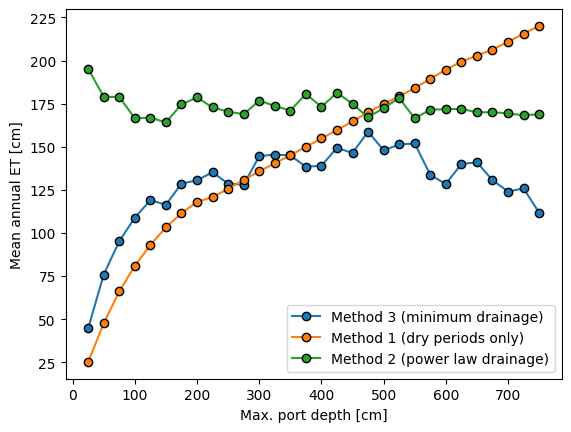

In [57]:
# plot effect of maximum node depth on mean annual ET

fig,ax = plt.subplots()
methodnames = {'Mymethod':'Method 3 (minimum drainage)',
               'Massbal':'Method 1 (dry periods only)',
               'Massbal_pl':'Method 2 (power law drainage)'}
for key in overall_performance_methods.keys():
  for nodespacing in [25]:#,50,100]:
    subset = overall_performance_methods[key]
    subset = subset[subset.Node_spacing==nodespacing]
    ax.plot(subset.num_ports*nodespacing,subset.ET_total,label=methodnames[key],
            marker='o',markeredgecolor = 'k')
ax.legend()
ax.set_xlabel('Max. port depth [cm]')
ax.set_ylabel('Mean annual ET [cm]')

<ipython-input-58-d0a34f28a551>:178: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


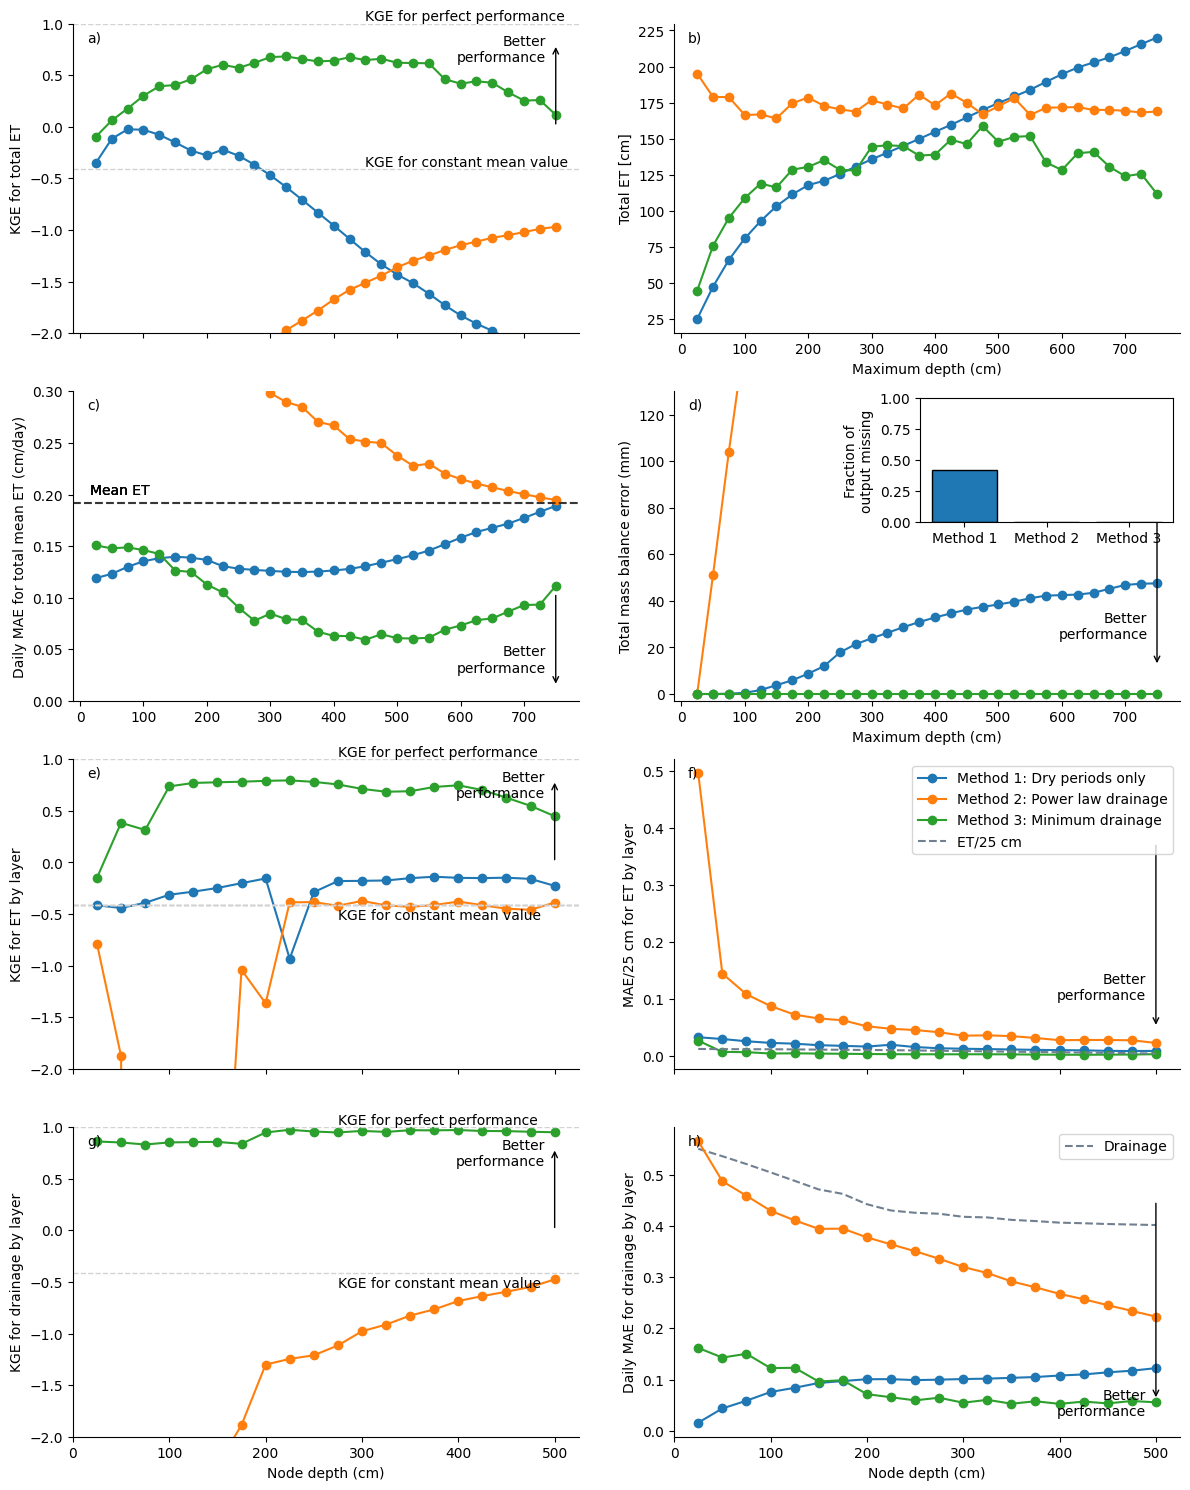

In [58]:
# plot method performance comparison for all three mass balance methods

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
titles = {'Mymethod': 'Method 3: Minimum drainage',
          'Massbal_pl':'Method 2: Power law drainage',
          'Massbal':'Method 1: Dry periods only'}
fig,axs = plt.subplots(4,2,figsize = (12,15),
                        #  sharey=True,
                        #  sharex=True
                        )
methodlist =['Massbal','Massbal_pl','Mymethod']
bestdepth=500

axins = inset_axes(axs[1,1],width='50%',height='40%',loc='upper right')

for tnumber,method in enumerate(methodlist):
  performance_all = performance_methods[method]
  overall_performance = overall_performance_methods[method]


  axs = axs.flatten()
  m=2
  for nodespacing in [performance_all.Node_spacing.min()]:
    spacedata = performance_all[(performance_all.Node_spacing==nodespacing) &
                                (performance_all.Num_ports*nodespacing==bestdepth)]
    ax = axs[2+m]
    ax.plot(spacedata.Node,spacedata.KGE,marker='o')
    ax.set_ylim(-1,1)
    ax.set_ylabel('KGE for ET by layer')
    ax.axhline(-.41,c='lightgrey',lw=1,ls='--')


    ax = axs[3+m]
    ax.plot(spacedata.Node,spacedata.MAE/nodespacing*25,marker='o',
            label=titles[method])
    if (nodespacing==25) & (method==methodlist[-1]):
      ax.plot(spacedata.Node,spacedata.meanET/nodespacing*25,ls='--',c='slategrey',
              label = 'ET/25 cm')
    ax.set_ylabel('MAE/25 cm for ET by layer')

    ax = axs[4+m]
    ax.plot(spacedata.Node,spacedata.KGE_flux,marker='o')
    ax.set_ylim(-1,1)
    ax.set_ylabel('KGE for drainage by layer')
    ax.set_xlabel('Node depth (cm)')


    ax = axs[5+m]
    ax.plot(spacedata.Node,spacedata.MAE_flux,marker='o',
            label=None)
    if (nodespacing==25) & (method==methodlist[0]):
      ax.plot(spacedata.Node,spacedata.meanFLUX,ls='--',c='slategrey',
              label = 'Drainage')
    ax.set_ylabel('Daily MAE for drainage by layer')
    ax.set_xlabel('Node depth (cm)')
    # ax.legend()


  ax = axs[0]
  axt = axs[2]
  ax1 = axs[3]
  ax3 = axs[1]
  ax2 = axins#s[3]
  for nodespace in [overall_performance.Node_spacing.min()]:
    spacedf = overall_performance[overall_performance.Node_spacing==nodespace]
    ax.plot(spacedf.maxdepth,
            spacedf.ET_totalKGE,
            marker='o',label=titles[method])
    ax3.plot(spacedf.maxdepth,
             spacedf.ET_total,marker='o',label=titles[method])
    axt.plot(spacedf.maxdepth,
            spacedf.ET_totalMAE,
            marker='o',)
    ax1.plot(spacedf.maxdepth,
            spacedf.massbal_error,
            marker = 'o',)
    if method=='Mymethod':
      vs = np.zeros(len(spacedf))
    else:
      vs = spacedf.missingData
    ax2.bar(tnumber,vs.mean(),edgecolor = 'k')
    # ax2.plot(spacedf.maxdepth,
    #         vs,
    #         marker = 'o')
  ax1.set_ylabel('Total mass balance error (mm)')
  ax1.set_ylim(-3,130)
  ax2.set_ylabel('Fraction of\noutput missing')
  ax2.set_ylim(0,1)
  ax2.set_xticks([0,1,2])
  ax2.set_xticklabels([titles[method].split(':')[0] for method in methodlist])

  for axn in [axt,ax1]:
    if axn==axt:
      pval = et.mean()
      hval = .2
      label = 'Mean ET'
      lval = 15
    else:
      pval = et.sum()
      hval = 120
      lval = 650
      label = 'Total ET'
    axn.axhline(pval,ls='--',c='k',alpha=.4)
    axn.text(lval,hval,label,)
  ax.set_ylim(-.5,1)
  ax.set_ylabel('KGE for total ET')
  ax1.set_xlabel('Maximum depth (cm)')
  ax3.set_xlabel('Maximum depth (cm)')
  axt.set_ylabel('Daily MAE for total mean ET (cm/day)')
  ax.set_xticklabels([])
  # axt.set_xticklabels([])
  axt.set_ylim(0,.3)
  ax3.set_ylabel('Total ET [cm]')

  for ax in [axs[3+m],axs[5+m]]:
    ax.legend()

  for ax in [axs[2+m],axs[3+m]]:
    ax.set_xlim(0,bestdepth+25)
    ax.set_xticklabels([])
  for ax in [axs[4+m],axs[5+m]]:
    ax.set_xlim(0,bestdepth+25)

  for axx in axs:
    for side in ['top','right']:
      axx.spines[side].set_visible(False)

import matplotlib.transforms as mtransforms

labels = ['a)','b)','c)','d)','e)',
          'f)','g)','h)','i)','j)']
for i,ax in enumerate(axs):
    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, labels[i], transform=ax.transAxes + trans,
            fontsize='medium', verticalalignment='top', )

for ax in [axs[0],axs[4],axs[6]]:
  ax.axhline(-.41,c='lightgrey',lw=1,ls='--')
  ax.axhline(1,c='lightgrey',lw=1,ls='--')
  if ax==axs[0]:
    xval = 450
    xval1 = 750
    yval = -.38
  else:
    xval = bestdepth*.55
    xval1 = bestdepth
    yval = -.55
  ax.text(xval,yval,'KGE for constant mean value')
  ax.text(xval,1.03,'KGE for perfect performance')
  ax.annotate("", xy=(xval1,0.8), xytext=(xval1,0),
            arrowprops=dict(arrowstyle="->"))
  ax.text(.98*xval1,.63,'Better\nperformance',ha = 'right')
  ax.set_ylim(-2,1)

for ax in [axs[2],axs[3],axs[5],axs[7]]:
  if ax in [axs[2],axs[3]]:
    xval1 = 750
    if ax==axs[2]:
      yval1 = .14
    else:
      yval1 = 120
  else:
    xval1 = bestdepth
    if ax==axs[5]:
      yval1 = .5#05
    else:
      yval1 = .6
  ax.annotate('',xy=(xval1,yval1*.75),xytext=(xval1,yval1*.1),
              arrowprops=dict(arrowstyle='<-'))
  if ax==axs[7]:
    top = .05*yval1
  else:
    top = .2*yval1
  ax.text(xval1*.98,top,
          'Better\nperformance',ha='right')

fig.tight_layout()

plt.savefig('allmethods_performance.png',format='png',dpi=300)

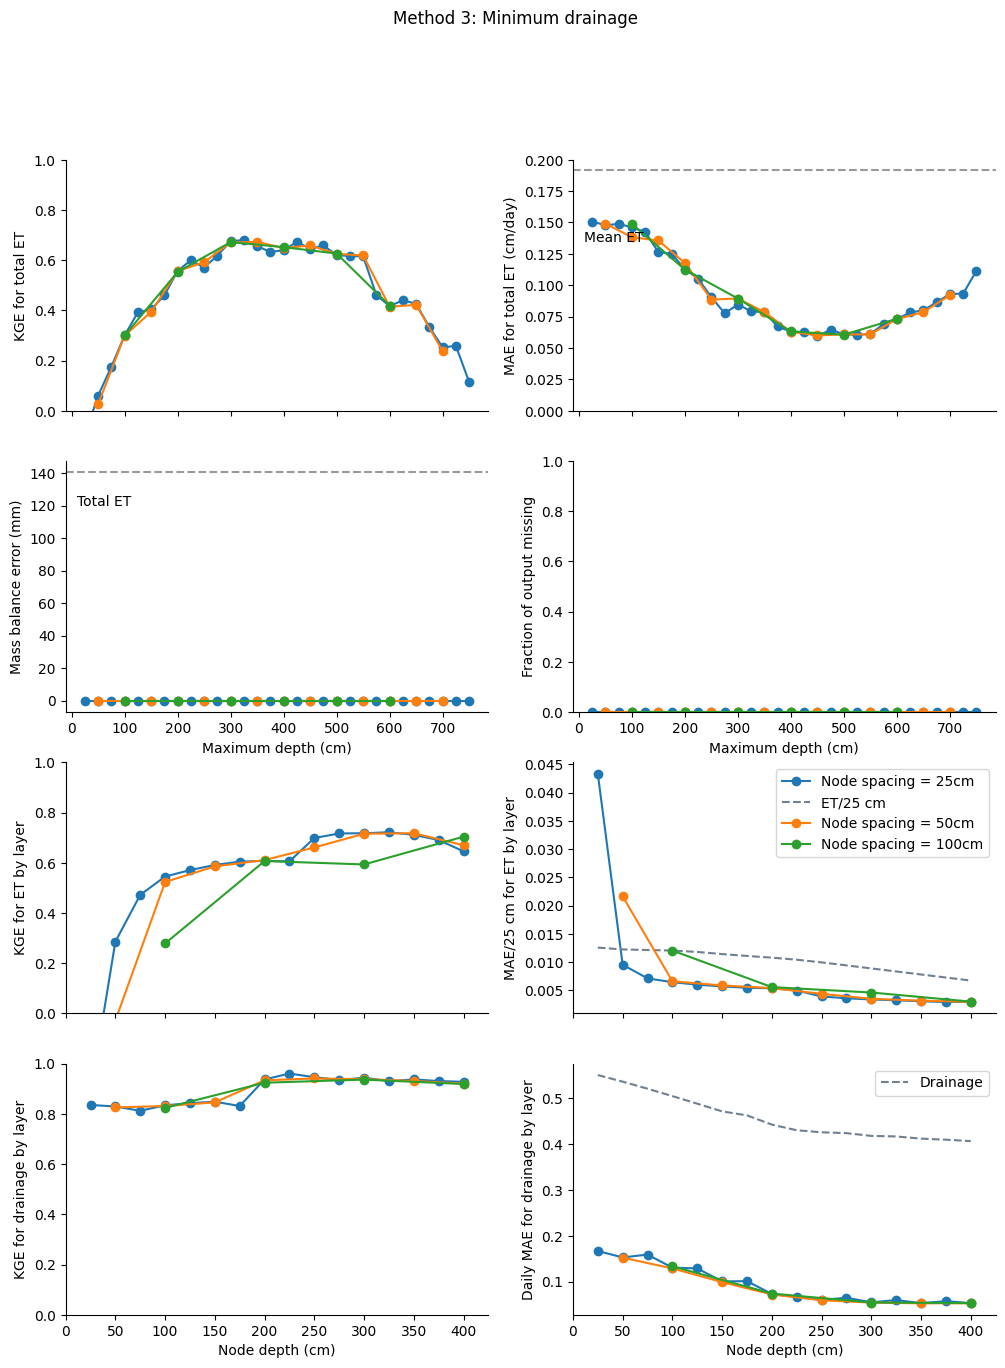

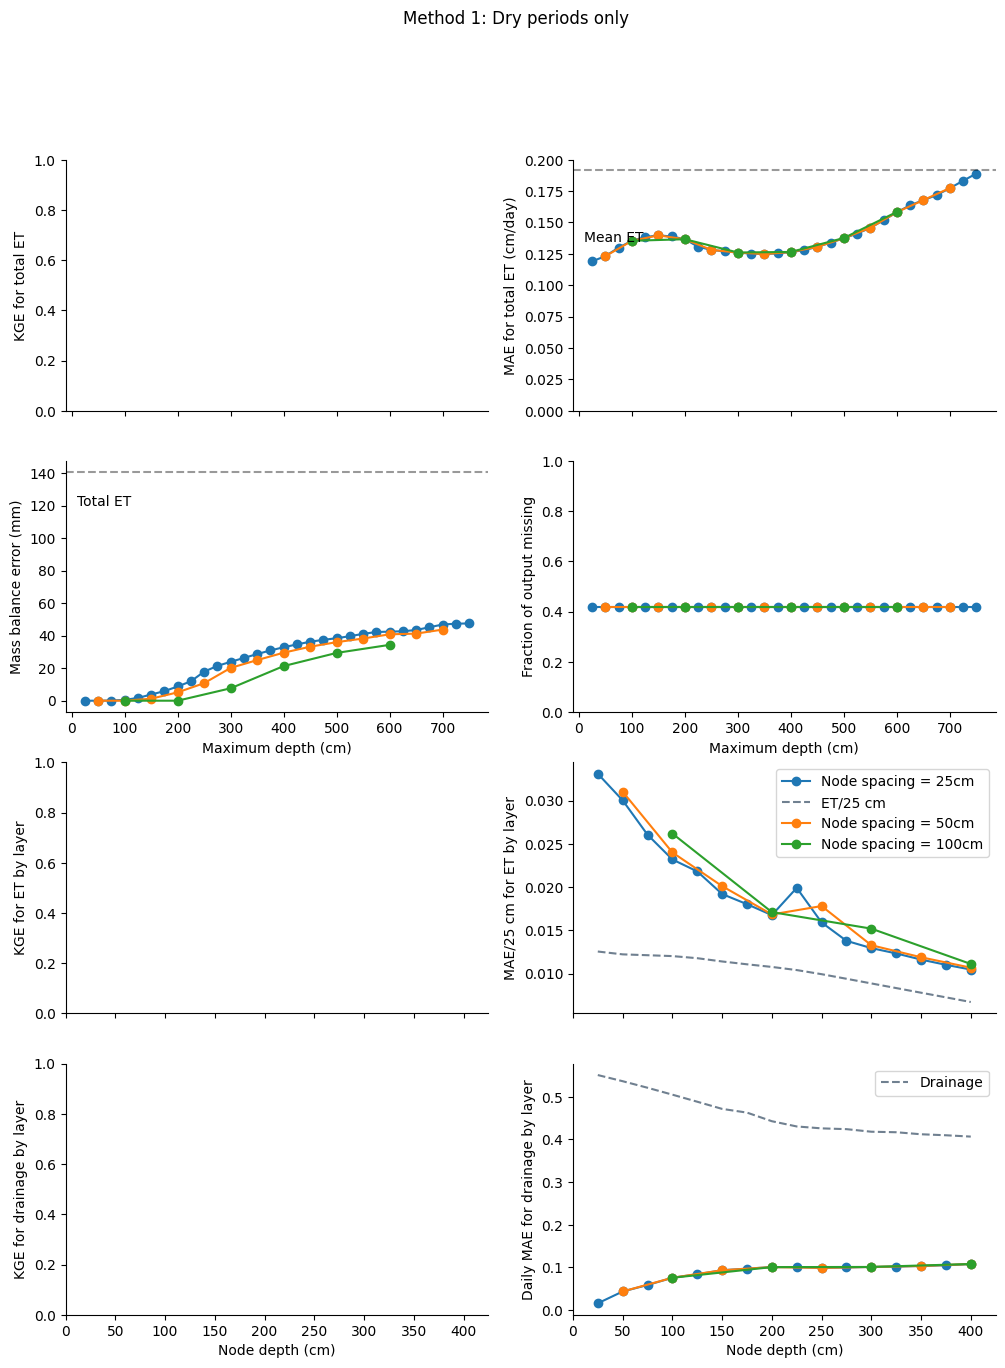

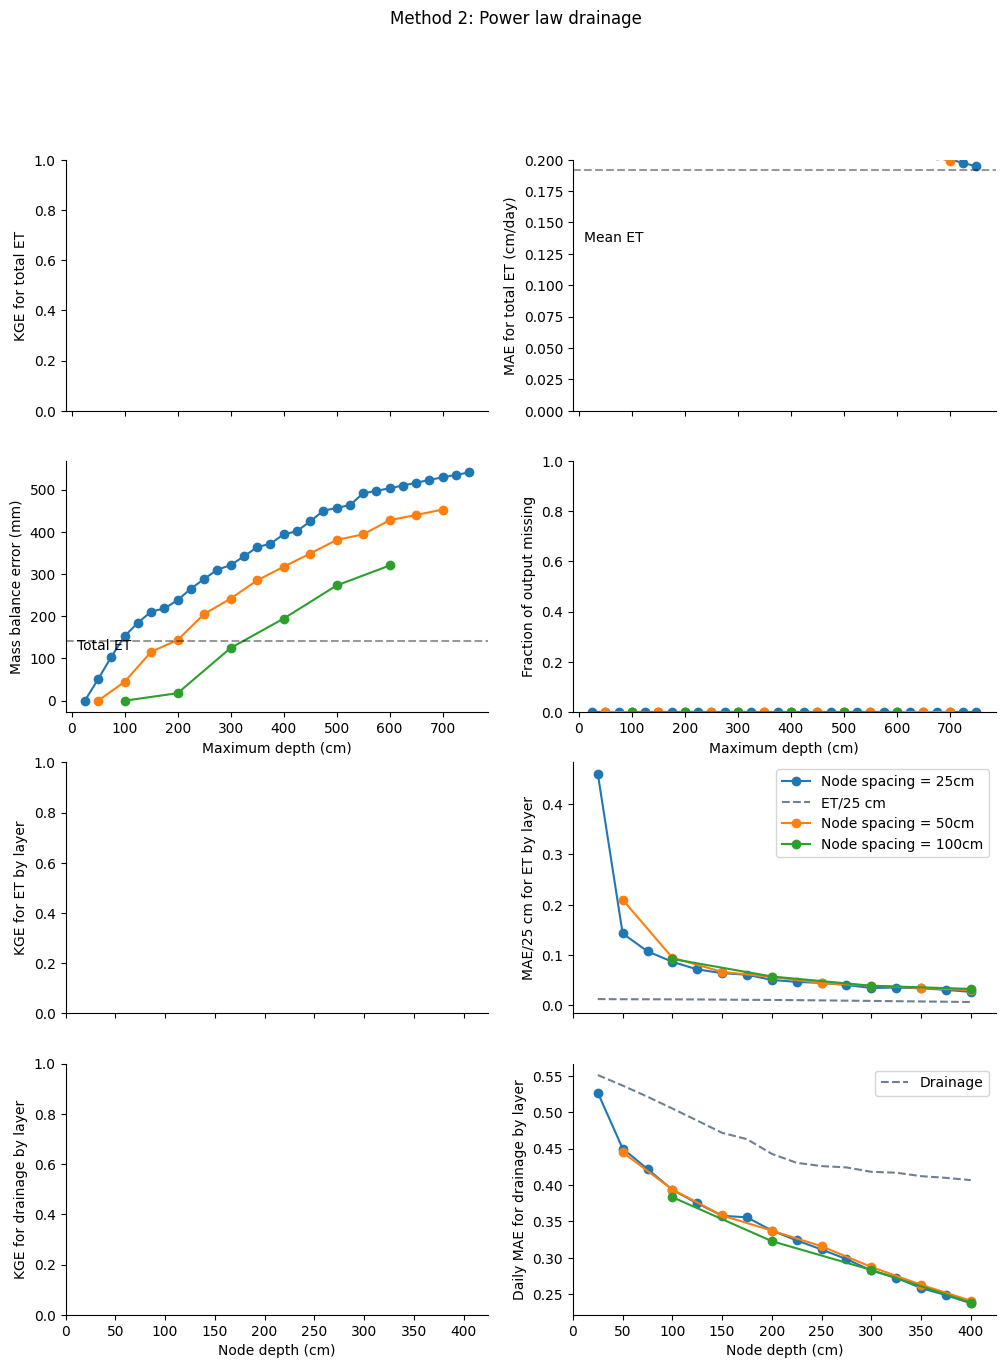

In [59]:
# plot method performance details for each method individually


titles = {'Mymethod': 'Method 3: Minimum drainage',
          'Massbal_pl':'Method 2: Power law drainage',
          'Massbal':'Method 1: Dry periods only'}

for method in fluxmethod_names.keys():
  performance_all = performance_methods[method]
  overall_performance = overall_performance_methods[method]

  fig,axs = plt.subplots(4,2,figsize = (12,15),
                        #  sharey=True,
                        #  sharex=True
                        )
  axs = axs.flatten()
  m=2
  for nodespacing in performance_all.Node_spacing.unique():
    spacedata = performance_all[(performance_all.Node_spacing==nodespacing) &
                                (performance_all.Num_ports*nodespacing==400)]
    ax = axs[2+m]
    ax.plot(spacedata.Node,spacedata.KGE,marker='o')
    ax.set_ylim(0,1)
    ax.set_ylabel('KGE for ET by layer')


    ax = axs[3+m]
    ax.plot(spacedata.Node,spacedata.MAE/nodespacing*25,marker='o',
            label='Node spacing = '+str(nodespacing)+'cm')
    if nodespacing==25:
      ax.plot(spacedata.Node,spacedata.meanET/nodespacing*25,ls='--',c='slategrey',
              label = 'ET/25 cm')
    ax.set_ylabel('MAE/25 cm for ET by layer')

    ax = axs[4+m]
    ax.plot(spacedata.Node,spacedata.KGE_flux,marker='o')
    ax.set_ylim(0,1)
    ax.set_ylabel('KGE for drainage by layer')
    ax.set_xlabel('Node depth (cm)')


    ax = axs[5+m]
    ax.plot(spacedata.Node,spacedata.MAE_flux,marker='o',
            label=None)
    if nodespacing==25:
      ax.plot(spacedata.Node,spacedata.meanFLUX,ls='--',c='slategrey',
              label = 'Drainage')
    ax.set_ylabel('Daily MAE for drainage by layer')
    ax.set_xlabel('Node depth (cm)')
    # ax.legend()


  ax = axs[0]
  axt = axs[1]
  ax1 = axs[2]
  ax2 = axs[3]
  for nodespace in overall_performance.Node_spacing.unique():
    spacedf = overall_performance[overall_performance.Node_spacing==nodespace]
    ax.plot(spacedf.maxdepth,
            spacedf.ET_totalKGE,
            marker='o',label='Node spacing = '+str(nodespace)+' cm')
    axt.plot(spacedf.maxdepth,
            spacedf.ET_totalMAE,
            marker='o',)
    ax1.plot(spacedf.maxdepth,
            spacedf.massbal_error,
            marker = 'o',)
    if method=='Mymethod':
      vs = np.zeros(len(spacedf))
    else:
      vs = spacedf.missingData
    ax2.plot(spacedf.maxdepth,
            vs,
            marker = 'o')
  ax1.set_ylabel('Mass balance error (mm)')
  ax2.set_ylabel('Fraction of output missing')
  ax2.set_ylim(0,1)

  for axn in [axt,ax1]:
    if axn==axt:
      pval = et.mean()
      hval = .135
      label = 'Mean ET'
    else:
      pval = et.sum()
      hval = 120
      label = 'Total ET'
    axn.axhline(pval,ls='--',c='k',alpha=.4)
    axn.text(10,hval,label,)
  # ax.legend(loc = 'lower right')
  ax.set_ylim(0,1)
  # ax.set_xlim(0,415)
  ax.set_ylabel('KGE for total ET')
  ax1.set_xlabel('Maximum depth (cm)')
  axt.set_ylabel('MAE for total ET (cm/day)')
  # axt.set_ylim(0,1.4)
  ax2.set_xlabel('Maximum depth (cm)')
  ax.set_xticklabels([])
  axt.set_xticklabels([])
  axt.set_ylim(0,.2)

  for ax in [axs[3+m],axs[5+m]]:
    ax.legend()

  for ax in [axs[2+m],axs[3+m]]:
    ax.set_xlim(0,425)
    ax.set_xticklabels([])
  for ax in [axs[4+m],axs[5+m]]:
    ax.set_xlim(0,425)

  for axx in axs:
    for side in ['top','right']:
      axx.spines[side].set_visible(False)

  fig.suptitle(titles[method])
  plt.savefig(method+'_performance.png',format='png',dpi=300)

In [60]:
# explore impact of temporal resolution

tresvals = [1,2,3,4,5,6,7,14,30]
fluxmethod_names = {
                    'Mymethod':calc_fluxes_mymethod,
                    # 'Massbal':calc_fluxes_massbal_only,
                    # 'Massbal_pl':calc_fluxes_massbal_powerlaw
                    }
performance_methods_tres = {key:[] for key in fluxmethod_names.keys()}
overall_performance_methods_tres = {key:[] for key in fluxmethod_names.keys()}
for key in fluxmethod_names.keys():
  fluxmethod = fluxmethod_names[key]
  performance_all = []
  overall_performance_all = []
  for nodespacing in [25]:
    for timespacing in tresvals:
      combodata, rain, pet, et, nodedepths = prep_data(nodespacing,timespacing)
      # for col in ['Flux','ETnode','deltaS','Prec']:
      #   combodata[col] = combodata[col].rolling(timespacing).sum()
      # combodata[combodata.time.astype('int').isin(list(range(0,int(combodata.time.max()),timespacing)))].dropna()
      DeltaStorages, portsdf = run_times(nodedepths,fluxmethod,timeres=timespacing)
      # if True:#nodespacing>50:
      #   performance = generate_performance(combodata,nodedepths,DeltaStorages,nodespacing)
      # else:
      #   performance = generate_performance(combodata,nodedepths,DeltaStorages)
      performance_all.append(performance)
      portsdf['Node_spacing'] = nodespacing
      overall_performance_all.append(portsdf)
  performance_all = pd.concat(performance_all)
  overall_performance = pd.concat(overall_performance_all)
  overall_performance['maxdepth'] = overall_performance.num_ports*overall_performance.Node_spacing

  performance_methods_tres[key] = performance_all
  overall_performance_methods_tres[key] = overall_performance

20
To meet mass balance, increased overall P by  0 %


<ipython-input-53-eea1cebc3a30>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


20
To meet mass balance, increased overall P by  0 %


<ipython-input-53-eea1cebc3a30>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


20
To meet mass balance, increased overall P by  0 %


<ipython-input-53-eea1cebc3a30>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


20
To meet mass balance, increased overall P by  0 %


<ipython-input-53-eea1cebc3a30>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


20
To meet mass balance, increased overall P by  0 %


<ipython-input-53-eea1cebc3a30>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


20
To meet mass balance, increased overall P by  0 %


<ipython-input-53-eea1cebc3a30>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


20
To meet mass balance, increased overall P by  0 %


<ipython-input-53-eea1cebc3a30>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


20
To meet mass balance, increased overall P by  0 %


<ipython-input-53-eea1cebc3a30>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


20
To meet mass balance, increased overall P by  0 %


<ipython-input-53-eea1cebc3a30>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ETerr[col] = np.where(ETerr[col]<0,ETerr[col].abs(),0)


<ipython-input-61-cf8c707d5b7d>:16: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  ax.axhline(1,c='k',ls='--')
<ipython-input-61-cf8c707d5b7d>:17: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  ax.axhline(-.41,c='k',ls='--')


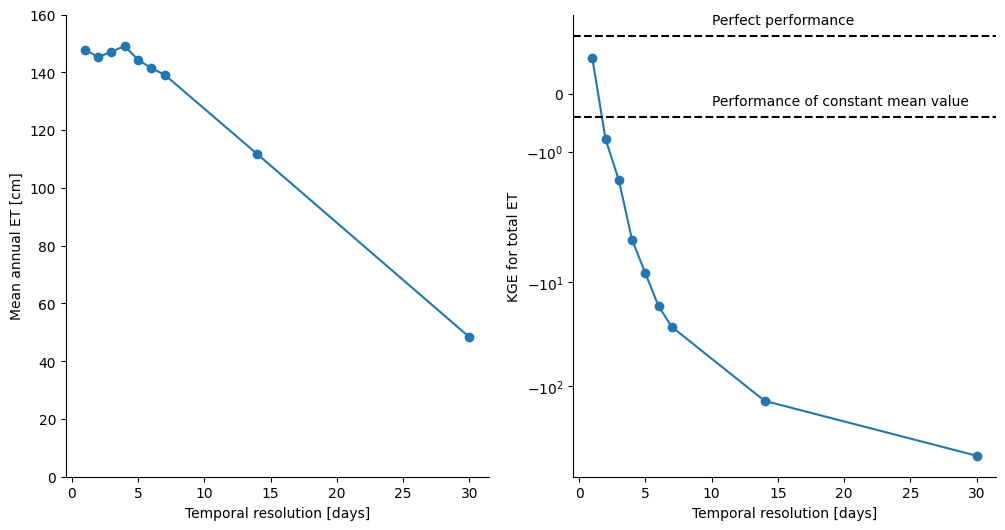

In [61]:
fig,axs = plt.subplots(1,2,figsize = (12,6))

ax = axs[0]
ax.plot(tresvals,
        overall_performance_methods_tres['Mymethod'].ET_total,marker='o')
ax.set_xlabel('Temporal resolution [days]')
ax.set_ylabel('Mean annual ET [cm]')
ax.set_ylim(0,160)

ax = axs[1]
ax.plot(tresvals,
        overall_performance_methods_tres['Mymethod'].ET_totalKGE,marker='o')
ax.set_xlabel('Temporal resolution [days]')
ax.set_ylabel('KGE for total ET')
ax.set_yscale('symlog')
ax.axhline(1,c='k',ls='--')
ax.axhline(-.41,c='k',ls='--')
ax.text(10,1.2,'Perfect performance')
ax.text(10,-.2,'Performance of constant mean value')

for ax in axs:
  ax.spines[['top','right']].set_visible(False)

plt.savefig('temporal_resolution_impact.png',format='png',dpi=300,bbox_inches='tight')

# Compare visually timeseries from different methods to HYDRUS

In [62]:
# run with best number of ports and high-res port spacing
num_ports = 20
nodespacing = 25
combodata, rain, pet, et, nodedepths = prep_data(nodespacing)
DeltaStorage_massbal = calc_fluxes_massbal_only(num_ports,nodespacing,)
DeltaStorage_mymethod = calc_fluxes_mymethod(num_ports,nodespacing)
DeltaStorage_massbal_pl = calc_fluxes_massbal_powerlaw(num_ports,nodespacing)

To meet mass balance, increased overall P by  0 %


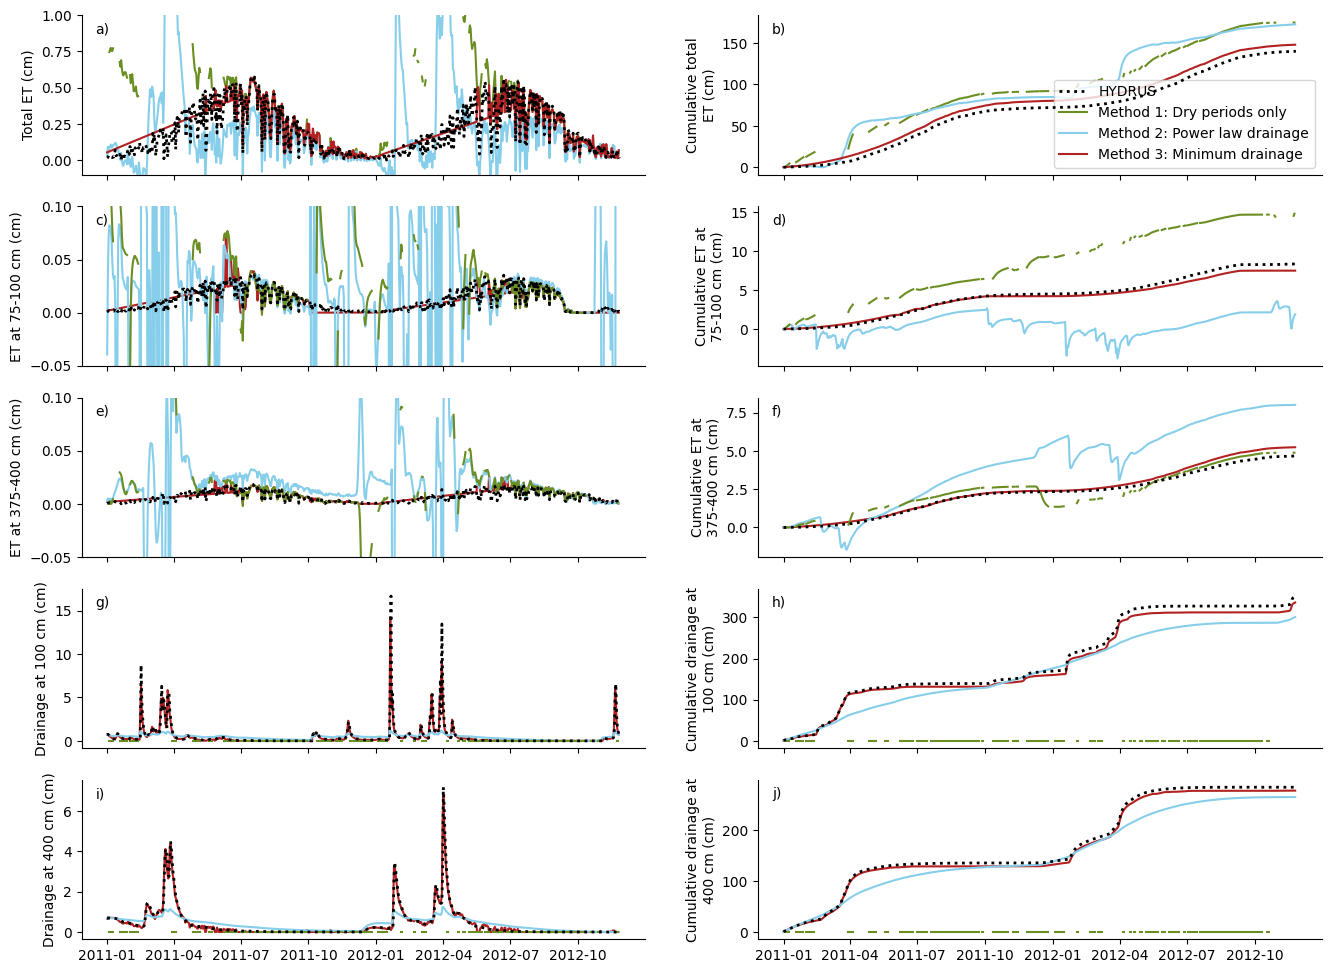

In [63]:
# visualize timeseries of ET and drainage from mass balance and HYDRUS

import matplotlib.gridspec as gridspec

fig = plt.figure(figsize = (16,12),)
gs = gridspec.GridSpec(5, 2)

axtotal = fig.add_subplot(gs[0, 0])
axet0   = fig.add_subplot(gs[1,0])
axet1   = fig.add_subplot(gs[2,0])
axd0    = fig.add_subplot(gs[3,0])
axd1    = fig.add_subplot(gs[4,0])
depth = int(100/nodespacing)
depth1 = int(400/nodespacing)

difftotal = fig.add_subplot(gs[0,1])
diffet = fig.add_subplot(gs[1,1])
diffet1 = fig.add_subplot(gs[2,1])
diffdrain = fig.add_subplot(gs[3,1])
diffdrain1 = fig.add_subplot(gs[4,1])

colors = ['firebrick','skyblue','olivedrab']
DeltaStorage_list = [DeltaStorage_mymethod,DeltaStorage_massbal_pl,DeltaStorage_massbal]
labellist = ['Mymethod','Massbal_pl','Massbal']

ax = difftotal
plotdata = combodata.groupby('time').sum().ETnode
ax.plot(dates[:len(plotdata)],
        plotdata.cumsum(),
        label = 'HYDRUS',c='k',ls=':',lw=2,zorder = 10)
ax.plot(dates[:len(DeltaStorage_massbal)],
        DeltaStorage_massbal.ET_total.cumsum(),
        label = titles['Massbal'],
        c = colors[2])
ax.plot(dates[:len(DeltaStorage_massbal_pl)],
        DeltaStorage_massbal_pl.ET_total.cumsum(),
        label = titles['Massbal_pl'],c = colors[1])
ax.plot(dates[:len(DeltaStorage_mymethod)],
        DeltaStorage_mymethod.ET_total.cumsum(),
        label=titles['Mymethod'],c = colors[0])
ax.legend(loc='lower right')
# ax.set_ylim(,1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Cumulative total\nET (cm)')
ax.set_xticklabels([])

ax = axtotal
plotdata = combodata.groupby('time').sum().ETnode
ax.plot(dates[:len(plotdata)],
        plotdata,
        label = 'HYDRUS',c='k',ls=':',lw=2,zorder = 10)
ax.plot(dates[:len(DeltaStorage_massbal)],
        DeltaStorage_massbal.ET_total,
        label = titles['Massbal'],
        c = colors[2])
ax.plot(dates[:len(DeltaStorage_massbal_pl)],
        DeltaStorage_massbal_pl.ET_total,
        label = titles['Massbal_pl'],c = colors[1])
ax.plot(dates[:len(DeltaStorage_mymethod)],
        DeltaStorage_mymethod.ET_total,
        label=titles['Mymethod'],c = colors[0])
# ax.legend()
ax.set_ylim(-0.1,1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Total ET (cm)')
ax.set_xticklabels([])

for i,node in enumerate([depth]):
  ax = axet0
  nodeET = combodata[combodata.Nodegroup==node][['ETnode','time']].groupby('time').sum()

  ax.plot(pd.to_datetime(dates[:len(nodeET)]),
          nodeET,
          c='k',ls=':',zorder = 5,label='HYDRUS ET',lw=2)
  for j in [2,1,0]:
    ax.plot(pd.to_datetime(dates[:len(DeltaStorage_list[j])]),
            DeltaStorage_list[j]['ET'+str(node)],
            label=titles[labellist[j]],zorder = j,
            c = colors[j])

  ax.set_xticklabels([])
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
ax.set_ylabel('ET at '+str((depth-1)*nodespacing)+'-'+str(depth*nodespacing)+' cm (cm)')
# ax.set_ylim(-.1,.1)
ax.set_ylim(-.05,.1)

for i,node in enumerate([depth]):
  ax = diffet
  nodeET = combodata[combodata.Nodegroup==node][['ETnode','time']].groupby('time').sum()

  ax.plot(pd.to_datetime(dates[:len(nodeET)]),
          nodeET.cumsum(),#.rolling(7).mean(),
          c='k',ls=':',zorder = 5,label='HYDRUS ET',lw=2)
  for j in [2,1,0]:
    ax.plot(pd.to_datetime(dates[:len(DeltaStorage_list[j])]),
            DeltaStorage_list[j]['ET'+str(node)].cumsum(),#.rolling(7).mean(),
            label=titles[labellist[j]],zorder = j,
            c = colors[j])

  ax.set_xticklabels([])
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
ax.set_ylabel('Cumulative ET at\n'+str((depth-1)*nodespacing)+'-'+str(depth*nodespacing)+' cm (cm)')


for i,node in enumerate([depth1]):
  ax = axet1
  nodeET = combodata[combodata.Nodegroup==node][['ETnode','time']].groupby('time').sum()

  ax.plot(pd.to_datetime(dates[:len(nodeET)]),
          nodeET,
          c='k',ls=':',zorder = 5,label='HYDRUS ET',lw=2)
  for j in [2,1,0]:
    ax.plot(pd.to_datetime(dates[:len(DeltaStorage_list[j])]),
            DeltaStorage_list[j]['ET'+str(node)],
            label=titles[labellist[j]],zorder = j,
            c = colors[j])

  ax.set_xticklabels([])
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
ax.set_ylabel('ET at '+str((depth1-1)*nodespacing)+'-'+str(depth1*nodespacing)+' cm (cm)')
ax.set_ylim(-.05,.1)

for i,node in enumerate([depth1]):
  ax = diffet1
  nodeET = combodata[combodata.Nodegroup==node][['ETnode','time']].groupby('time').sum()

  ax.plot(pd.to_datetime(dates[:len(nodeET)]),
          nodeET.cumsum(),#.rolling(7).mean(),
          c='k',ls=':',zorder = 5,label='HYDRUS ET',lw=2)
  for j in [2,1,0]:
    ax.plot(pd.to_datetime(dates[:len(DeltaStorage_list[j])]),
            DeltaStorage_list[j]['ET'+str(node)].cumsum(),#.rolling(7).mean(),
            label=titles[labellist[j]],zorder = j,
            c = colors[j])

  ax.set_xticklabels([])
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
ax.set_ylabel('Cumulative ET at\n'+str((depth1-1)*nodespacing)+'-'+str(depth1*nodespacing)+' cm (cm)')


daxes = [diffdrain,diffdrain1]
for nn,n in enumerate([depth,depth1]):
  ax = daxes[nn]
  hydrusts = (-combodata[combodata.Nodegroup==n].set_index('time').Flux)
  ax.plot(dates[:len(hydrusts)],
                hydrusts.cumsum(),
          ls=':',label='HYDRUS drainage',zorder =10,c='k',lw=2)

  for j in [2,1,0]:
    calcts = DeltaStorage_list[j]['d'+str(n)]
    ax.plot(dates[:len(calcts)],calcts.cumsum(),
            label=titles[labellist[j]],zorder = j,c = colors[j])

  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.set_ylabel('Cumulative drainage at\n'+str(n*nodespacing)+' cm (cm)')
  if nn==0:
    ax.set_xticklabels([])
# ax.legend(loc='lower right')

daxes = [axd0,axd1]
for nn,n in enumerate([depth,depth1]):
  ax = daxes[nn]
  hydrusts = (-combodata[combodata.Nodegroup==n].set_index('time').Flux)
  ax.plot(dates[:len(hydrusts)],
                hydrusts,
          ls=':',label='HYDRUS drainage',zorder =10,c='k',lw=2)

  for j in [2,1,0]:
    calcts = DeltaStorage_list[j]['d'+str(n)]
    ax.plot(dates[:len(calcts)],calcts,
            label=titles[labellist[j]],zorder = j,c = colors[j])

  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.set_ylabel('Drainage at '+str(n*nodespacing)+' cm (cm)')
  if nn==0:
    ax.set_xticklabels([])
# ax.legend(loc='lower right')



labels = ['a)','b)','c)','d)','e)','f)','g)','h)','i)','j)','k)','l)']
for i,ax in enumerate([axtotal,difftotal,
                       axet0,diffet,
                       axet1,diffet1,
                       axd0,diffdrain,
                       axd1,diffdrain1
                       ]):
    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, labels[i], transform=ax.transAxes + trans,
            fontsize='medium', verticalalignment='top', )
plt.savefig('timeseries_output.png',format='png',dpi=300,bbox_inches='tight')

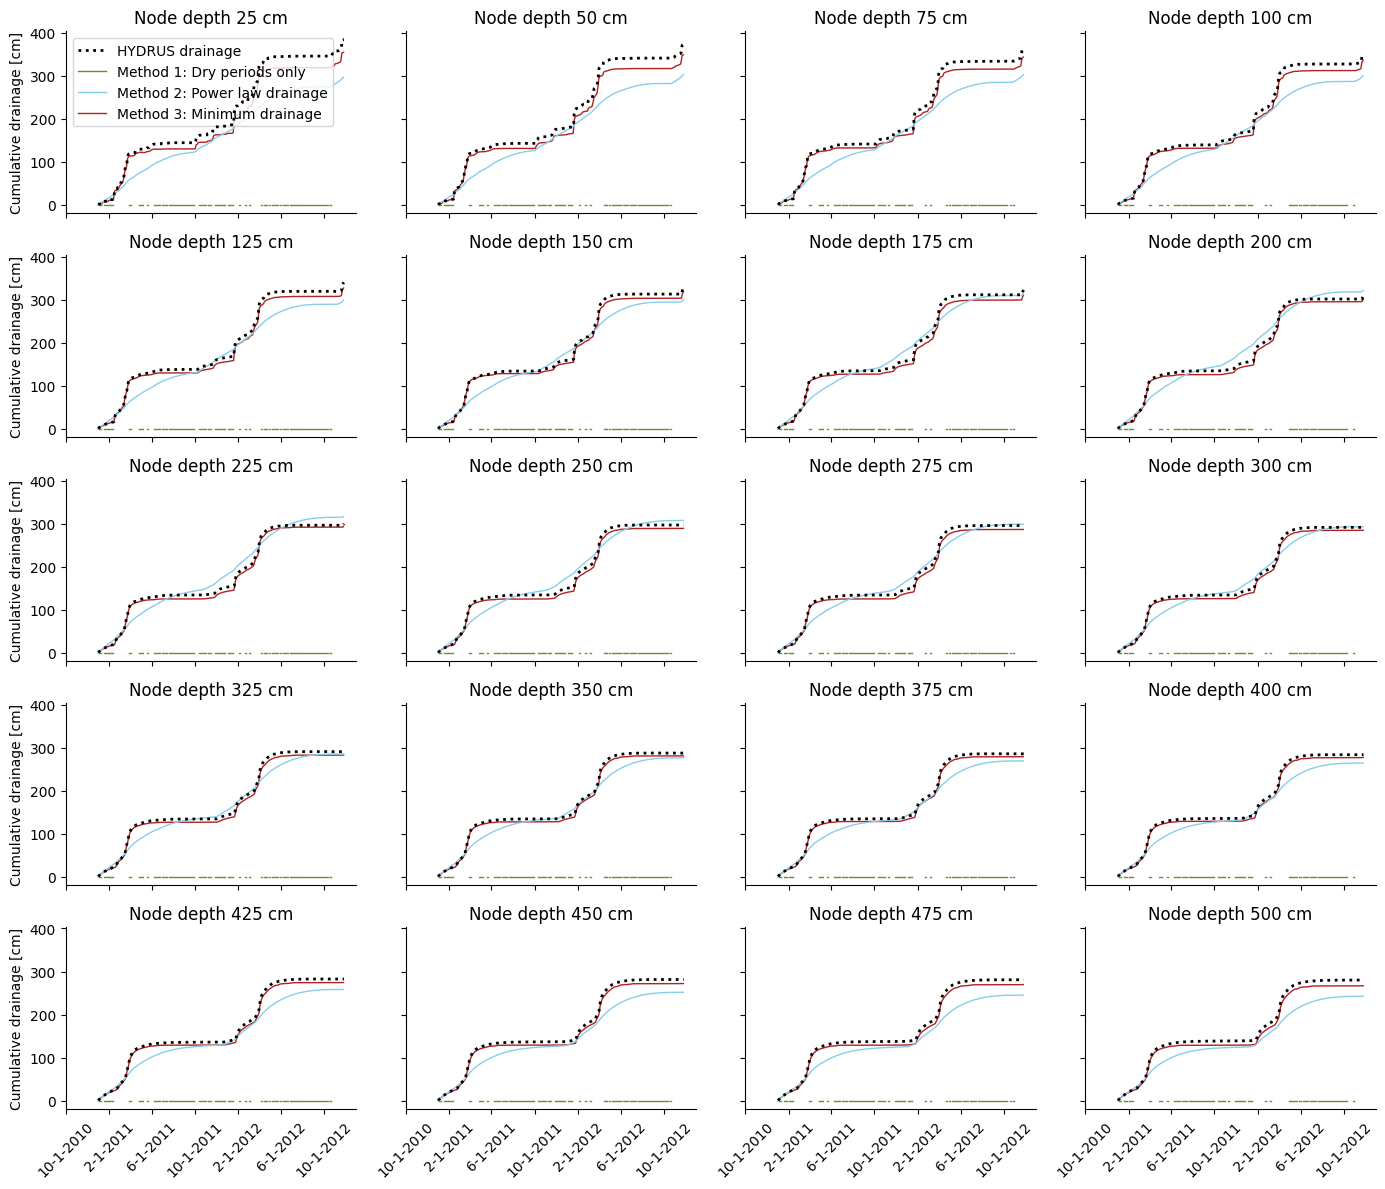

In [67]:
DeltaStorage_list = [DeltaStorage_mymethod,DeltaStorage_massbal_pl,DeltaStorage_massbal]
labellist = ['Mymethod','Massbal_pl','Massbal']


fig,axs = plt.subplots(5,4,figsize = (14,12),sharey=True,sharex=True)
axs = axs.flatten()
for n in range(1,num_ports+1):

  ax = axs[n-1]
  hydrusts = (-combodata[combodata.Nodegroup==n].set_index('time').Flux)
  ax.plot(dates[:len(hydrusts)],
                hydrusts.cumsum(),
          ls=':',label='HYDRUS drainage',zorder =10,c='k',lw=2)

  for j in [2,1,0]:
    calcts = DeltaStorage_list[j]['d'+str(n)]
    ax.plot(dates[:len(calcts)],calcts.cumsum(),
            label=titles[labellist[j]],zorder = j,c = colors[j],lw=1)
  ax.set_title('Node depth '+str(n*nodespacing)+' cm')
  ax.set_xticks([pd.to_datetime(d) for d in ['10-1-2010','2-1-2011',
                                          '6-1-2011','10-1-2011','2-1-2012',
              '6-1-2012','10-1-2012']],
               ['10-1-2010','2-1-2011',
                                          '6-1-2011','10-1-2011','2-1-2012',
              '6-1-2012','10-1-2012'],
             rotation=45)
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  if n==1:
    ax.legend()


for ax in axs[::4]:
  ax.set_ylabel('Cumulative drainage [cm]')

fig.tight_layout()
plt.savefig('drainage_timeseries.png',format='png',dpi=300)

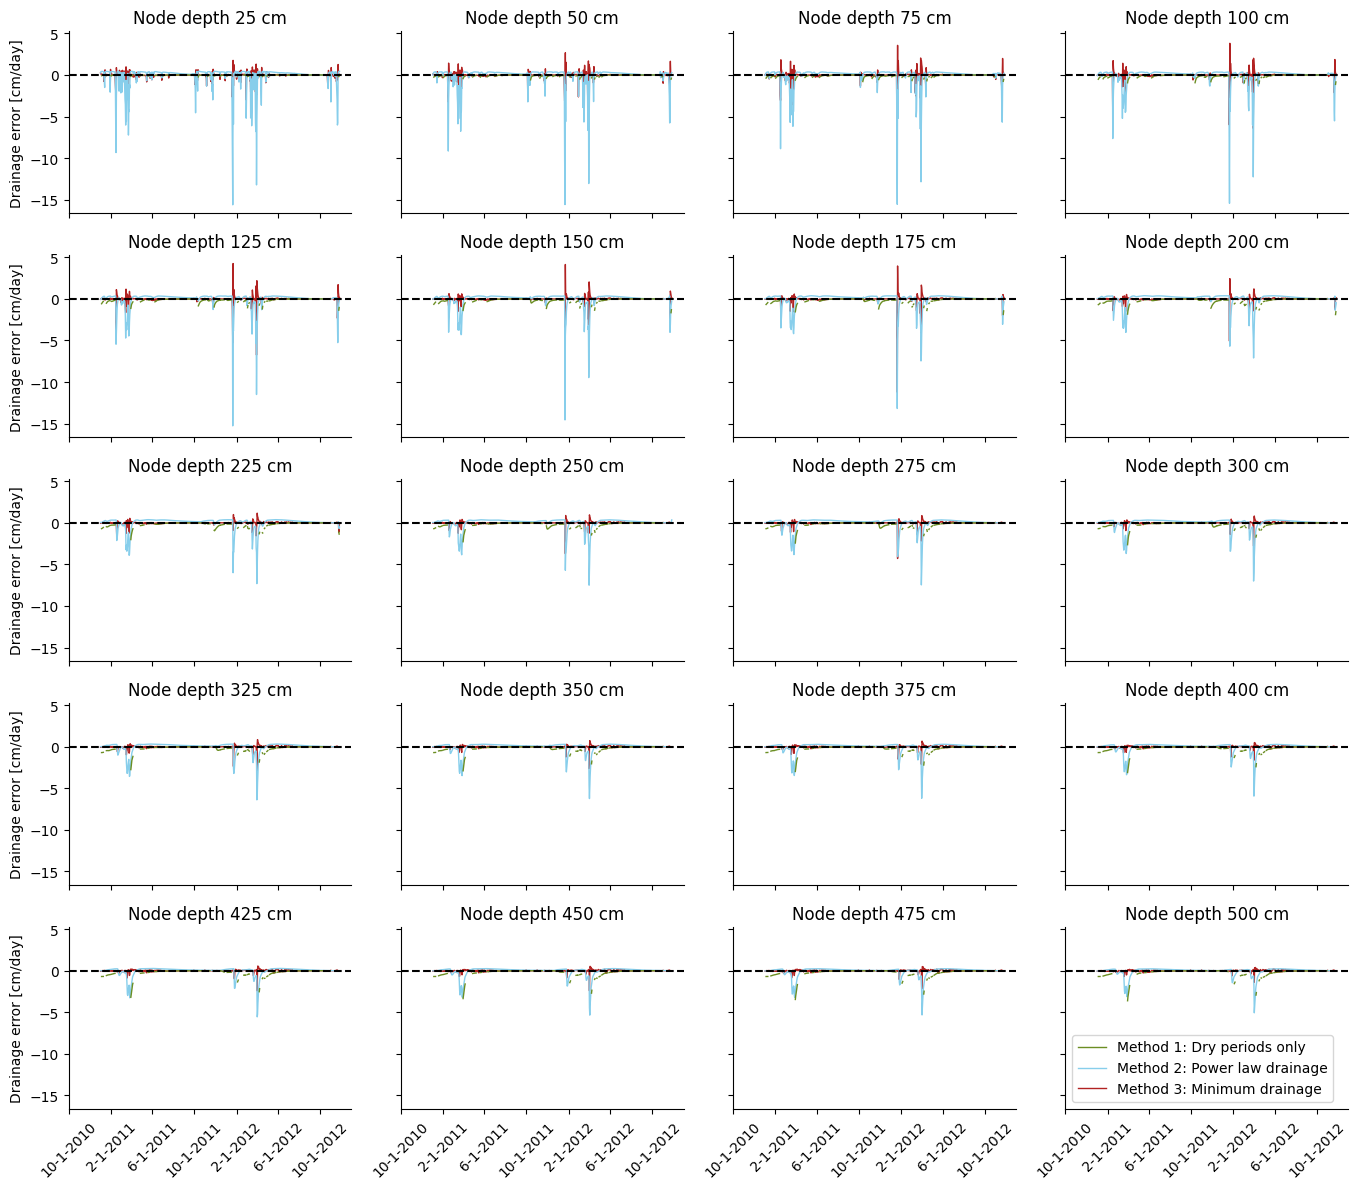

In [68]:

DeltaStorage_list = [DeltaStorage_mymethod,DeltaStorage_massbal_pl,DeltaStorage_massbal]
labellist = ['Mymethod','Massbal_pl','Massbal']


fig,axs = plt.subplots(5,4,figsize = (14,12),sharey=True,sharex=True)
axs = axs.flatten()
for n in range(1,num_ports+1):
  ax = axs[n-1]
  hydrusts = (-combodata[combodata.Nodegroup==n].set_index('time').Flux)
  # ax.plot(dates[:len(hydrusts)],
  #               hydrusts,ls=':',label='HYDRUS drainage',zorder =10,c='k',lw=2)

  for j in [2,1,0]:
    calcts = DeltaStorage_list[j]['d'+str(n)]
    ax.plot(dates[:len(hydrusts)],calcts-hydrusts,
            label=titles[labellist[j]],zorder = j,c = colors[j],lw=1)
  ax.set_title('Node depth '+str(n*nodespacing)+' cm')
  # print(n,kge(hydrusts.iloc[365:],calcts.iloc[365:]))
  # ax.set_xlim(365,730)
  ax.set_xticks([pd.to_datetime(d) for d in ['10-1-2010','2-1-2011',
                                          '6-1-2011','10-1-2011','2-1-2012',
              '6-1-2012','10-1-2012']],
               ['10-1-2010','2-1-2011',
                                          '6-1-2011','10-1-2011','2-1-2012',
              '6-1-2012','10-1-2012'],
             rotation=45)
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.axhline(0,c='k',ls='--')
ax.legend()

for ax in axs[::4]:
  ax.set_ylabel('Drainage error [cm/day]')

fig.tight_layout()
plt.savefig('drainage_timeseries_diffs.png',format='png',dpi=300)

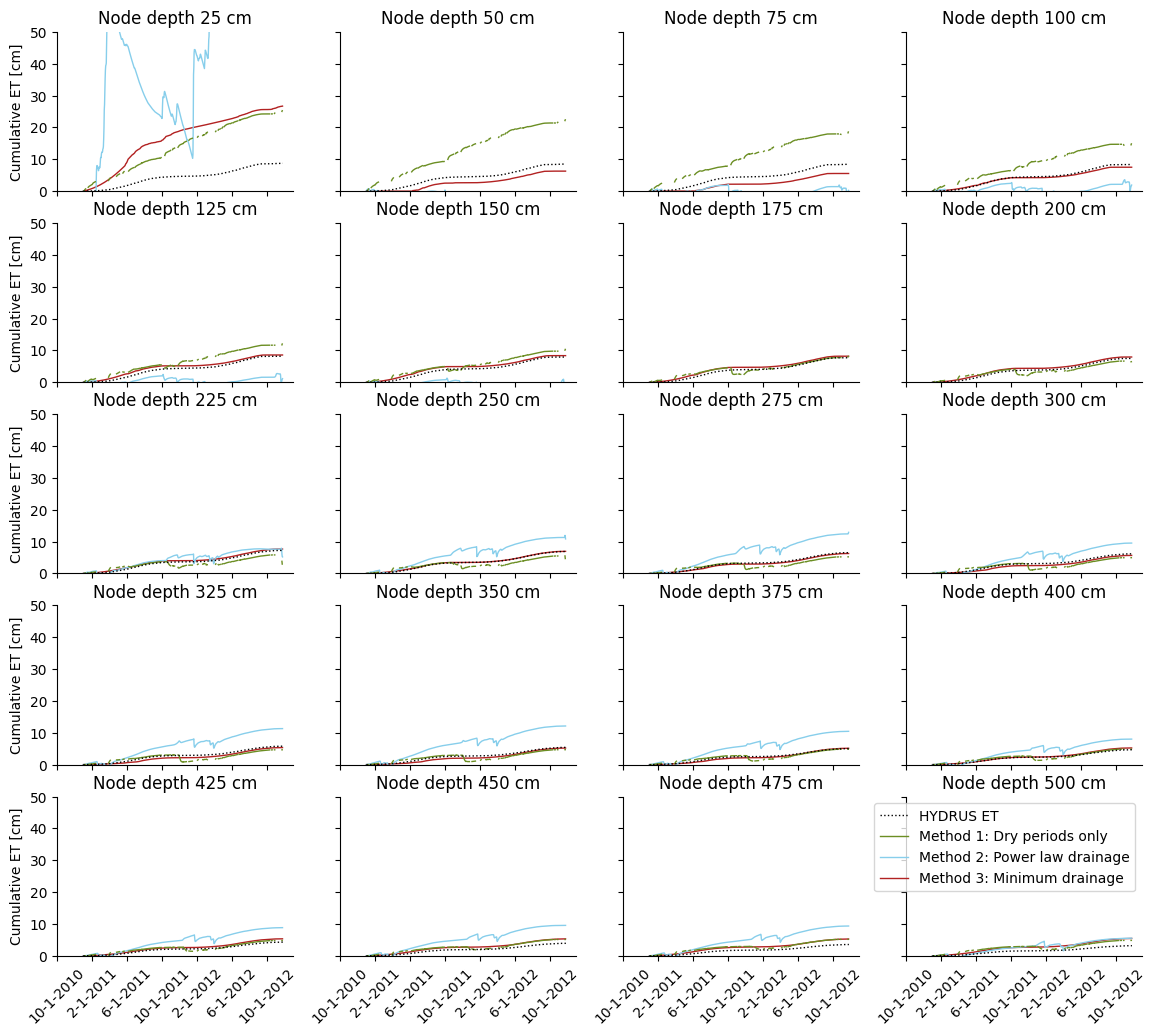

In [69]:
fig,axs = plt.subplots(5,4,figsize = (14,12),sharex=True,sharey=True)
axs = axs.flatten()
for i,node in enumerate(list(range(1,num_ports+1))):
  ax = axs[i]
  nodeET = combodata[combodata.Nodegroup==node][['ETnode','time']].groupby('time').sum()#set_index('time')

  ax.plot(pd.to_datetime(dates[:len(nodeET)]),
          nodeET.cumsum(),#rolling(7).mean(),
          c='k',lw=1,ls=':',zorder = 5,label='HYDRUS ET')
  for j in [2,1,0]:
    ax.plot(pd.to_datetime(dates[:len(DeltaStorage_list[j])]),
            DeltaStorage_list[j]['ET'+str(node)].cumsum(),#rolling(7).mean(),
            label=titles[labellist[j]],lw=1,zorder = j,c = colors[j])
  ax.set_title('Node depth '+str(node*nodespacing)+' cm')
  ax.set_xticks([pd.to_datetime(d) for d in ['10-1-2010','2-1-2011',
                                          '6-1-2011','10-1-2011','2-1-2012',
              '6-1-2012','10-1-2012']],
               ['10-1-2010','2-1-2011',
                                          '6-1-2011','10-1-2011','2-1-2012',
              '6-1-2012','10-1-2012'],
             rotation=45)
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
ax.legend()
ax.set_ylim(0,50)
for ax in axs[::4]:
  ax.set_ylabel('Cumulative ET [cm]')
plt.savefig('ET_timeseries.png',format='png',dpi=300)


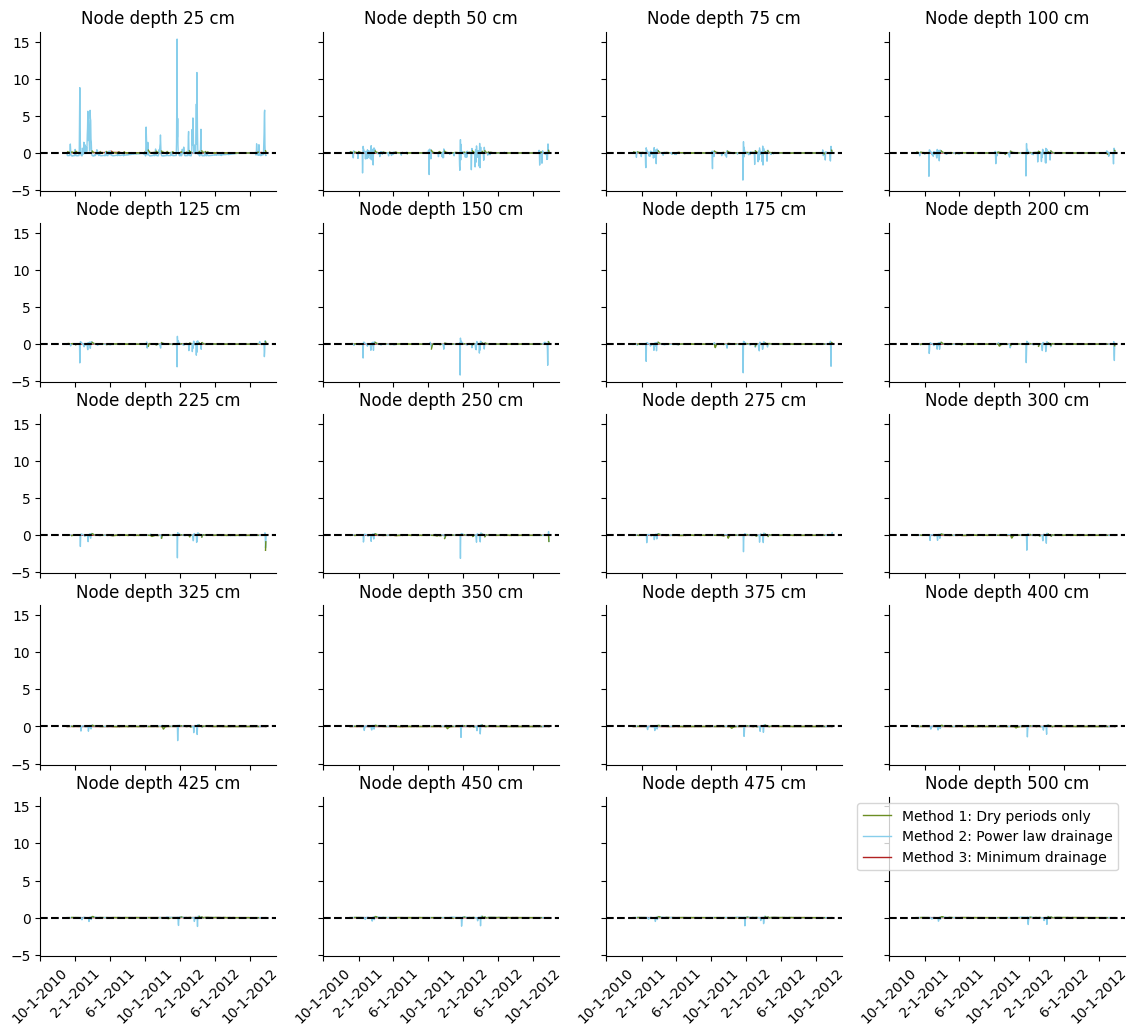

In [70]:
fig,axs = plt.subplots(5,4,figsize = (14,12),sharex=True,sharey=True)
axs = axs.flatten()
for i,node in enumerate(list(range(1,num_ports+1))):
  ax = axs[i]
  nodeET = combodata[combodata.Nodegroup==node][['ETnode','time']].set_index('time')

  # ax.plot(pd.to_datetime(dates[:len(nodeET)]),
  #         nodeET,c='k',lw=1,ls=':',zorder = 5,label='HYDRUS ET')
  for j in [2,1,0]:
    ax.plot(pd.to_datetime(dates[:len(nodeET)]),
            DeltaStorage_list[j]['ET'+str(node)]-nodeET['ETnode'],
            label=titles[labellist[j]],lw=1,zorder = j,c = colors[j])
  ax.set_title('Node depth '+str(node*25)+' cm')
  ax.set_xticks([pd.to_datetime(d) for d in ['10-1-2010','2-1-2011',
                                          '6-1-2011','10-1-2011','2-1-2012',
              '6-1-2012','10-1-2012']],
               ['10-1-2010','2-1-2011',
                                          '6-1-2011','10-1-2011','2-1-2012',
              '6-1-2012','10-1-2012'],
             rotation=45)
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.axhline(0,c='k',ls='--')
ax.legend()
plt.savefig('ET_timeseries_diffs.png',format='png',dpi=300)
